## Dataset description

The goal of this competition is to analyze horse racing tactics, drafting strategies, and path efficiency. You will develop a model using never-before-released coordinate data along with basic race information.

Your work will help racing horse owners, trainers, and veterinarians better understand how equine performance and welfare fit together. With better data analysis, equine welfare could significantly improve.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import warnings # Supress warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from datetime import datetime
from meteostat import Point, Daily, Hourly

In [2]:
sns.set(rc={"figure.figsize":(15, 5)})

In [3]:
df = pd.read_csv(
    '.../Kaggle/Big Data Derby 2022/nyra_2019_complete.csv',
    parse_dates=['race_date'],
    names=['track_id', 'race_date', 'race_number', 'program_number','trakus_index', 'latitude',
           'longitude', 'distance_id', 'course_type', 'track_condition', 'run_up_distance',
           'race_type', 'purse', 'post_time', 'weight_carried', 'jockey', 'odds', 'position_at_finish'])
df.head()

,track_id,race_date,race_number,program_number,trakus_index,latitude,longitude,distance_id,course_type,track_condition,run_up_distance,race_type,purse,post_time,weight_carried,jockey,odds,position_at_finish
0,AQU,2019-01-01,9,6,72,40.672902,-73.827607,600,D,GD,48,CLM,25000.0,420,120,Andre Shivnarine Worrie,2090,8
1,AQU,2019-01-01,9,6,73,40.672946,-73.827587,600,D,GD,48,CLM,25000.0,420,120,Andre Shivnarine Worrie,2090,8
2,AQU,2019-01-01,9,6,74,40.672990,-73.827568,600,D,GD,48,CLM,25000.0,420,120,Andre Shivnarine Worrie,2090,8
3,AQU,2019-01-01,9,6,63,40.672510,-73.827781,600,D,GD,48,CLM,25000.0,420,120,Andre Shivnarine Worrie,2090,8
4,AQU,2019-01-01,9,6,64,40.672553,-73.827762,600,D,GD,48,CLM,25000.0,420,120,Andre Shivnarine Worrie,2090,8


In [4]:
df_start = pd.read_csv('nyra_start_table.csv', 
                       header=None, 
                       parse_dates=['race_date'],
                       names=['track_id',
                              'race_date',
                              'race_number',
                              'program_number',
                              'weight_carried',
                              'jockey',
                              'odds',
                              'position_at_finish'])
df_start.head()

,track_id,race_date,race_number,program_number,weight_carried,jockey,odds,position_at_finish
0,AQU,2019-01-01,1,1,123,Dylan Davis,130,2
1,AQU,2019-01-01,1,2,120,Junior Alvarado,295,3
2,AQU,2019-01-01,1,3,118,Jose Lezcano,180,4
3,AQU,2019-01-01,1,4,123,Jomar Garcia,1280,5
4,AQU,2019-01-01,1,5,118,Manuel Franco,1150,1


In [5]:
df_race = pd.read_csv('nyra_race_table.csv', parse_dates=['race_date'])
df_race.head()

,track_id,race_date,race_number,distance_id,course_type,track_condition,run_up_distance,race_type,purse,post_time
0,AQU,2019-01-01,1,650,D,MY,36,AOC,80000,1220
1,AQU,2019-01-01,2,600,D,MY,48,MCL,41000,1250
2,AQU,2019-01-01,3,550,D,MY,54,MCL,35000,121
3,AQU,2019-01-01,4,900,D,MY,101,AOC,80000,150
4,AQU,2019-01-01,5,700,D,MY,60,ALW,64000,220


In [6]:
df_tracking = pd.read_csv('nyra_tracking_table.csv', parse_dates=['race_date'])
df_tracking.head()

,track_id,race_date,race_number,program_number,trakus_index,latitude,longitude
0,AQU,2019-01-01,9,6,72,40.672902,-73.827607
1,AQU,2019-01-01,9,6,73,40.672946,-73.827587
2,AQU,2019-01-01,9,6,74,40.672990,-73.827568
3,AQU,2019-01-01,9,6,63,40.672510,-73.827781
4,AQU,2019-01-01,9,6,64,40.672553,-73.827762


Dataset has 3 files merged into one nyra_2019_complete.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5228430 entries, 0 to 5228429
Data columns (total 18 columns):
 #   Column              Dtype         
---  ------              -----         
 0   track_id            object        
 1   race_date           datetime64[ns]
 2   race_number         int64         
 3   program_number      object        
 4   trakus_index        int64         
 5   latitude            float64       
 6   longitude           float64       
 7   distance_id         int64         
 8   course_type         object        
 9   track_condition     object        
 10  run_up_distance     int64         
 11  race_type           object        
 12  purse               float64       
 13  post_time           int64         
 14  weight_carried      int64         
 15  jockey              object        
 16  odds                int64         
 17  position_at_finish  int64         
dtypes: datetime64[ns](1), float64(3), int64(8), object(6)
memory usage: 718.0+ MB


File consists of 18 columns and 5 228 430 rows.

The meaning of the columns names provided by NYTHA/NYRA:
 - race_date: date the race took place. YYYY-MM-DD.
 - race_number: Number of the race. Passed as 3 characters but can be cast or converted to int for this data set.
 - program_number: Program number of the horse in the race passed as 3 characters. Should remain 3 characters as it isn't limited to just numbers. Is essentially the unique identifier of the horse in the race.
 - trakus_index: The common collection of point of the lat / long of the horse in the race passed as an integer. From what we can tell, it's collected every 0.25 seconds.
 - latitude: The latitude of the horse in the race passed as a float.
 - longitude: The longitude of the horse in the race passed as a float.
 - distance_id: Distance of the race in furlongs passed as an integer. Example - 600 would be 6 furlongs.
 - course_type: The course the race was run over passed as one character. M - Hurdle, D - Dirt, O - Outer turf, I - Inner turf, T - turf.
 - track_condition: The condition of the course the race was run on passed as three characters. YL - Yielding, FM - Firm, SY - Sloppy, GD - Good, FT - Fast, MY - Muddy, SF - Soft.
 - run_up_distance: Distance in feet of the gate to the start of the race passed as an integer.
 - race_type: The classification of the race passed as as five characters. STK - Stakes, WCL - Waiver Claiming, WMC - Waiver Maiden Claiming, SST - Starter Stakes, SHP - Starter Handicap, CLM - Claiming, STR - Starter Allowance, AOC - Allowance Optionl Claimer, SOC - Starter Optional Claimer, MCL - Maiden Claiming, ALW - Allowance, MSW - Maiden Special Weight.
 - purse: Purse in US dollars of the race passed as an money with two decimal places.
 - post_time: Time of day the race began passed as 5 character. Example - 01220 would be 12:20.
 - weight_carried: An integer of the weight carried by the horse in the race.
 - jockey: Name of the jockey on the horse in the race. 50 character max.
 - odds: Odds to win the race passed as an integer. Divide by 100 to derive the odds to 1. Example - 1280 would be 12.8-1.
 - position_at_finish: An integer of the horse's finishing position.
 
 Dataset contains following data types: datetime64[ns](1), float64(3), int64(8), object(6).

## Data types changing

### program_number

In [8]:
df.program_number.unique() # unique values of the column

array(['6  ', '2  ', '9  ', '3  ', '1  ', '11 ', '5  ', '4  ', '10 ',
       '7  ', '1A ', '8  ', '13 ', '2B ', '12 ', '14 ', '15 ', 3, 12, 2,
       4, 7, 11, 6, 1, 5, 8, 9, 10, 13, 14, 15, '16 ', 16, '3X ', '1X '],
      dtype=object)

We see object and int number formats at the same time.

In [9]:
df['program_number'] = df['program_number'].astype(str) # entire column to str
df['program_number'] = df['program_number'].str.strip() # strip spaces

### post_time

In [10]:
df.post_time.unique()

array([ 420,  442,  624,  412,  210,  228,  155,  410, 1255, 1259,  308,
        519,  406,  400,  522,  229,  223,  134,  238, 1250,  521,  225,
        300,  234,  240, 1245,  128,  227, 1256,  441,  615,  205, 1200,
       1232,  230,  546,  203,  413,  311,  102,  433,  218,  156,  334,
        259,  430,  457,  248,  304,  409,  451,  307, 1231,  312,  341,
        233,  656,  418,  131,  327,  130,  445,  358,  524,  646,  515,
        202,  226,  330,  555,  506,  150,  425,  321,  623,  326,  331,
        443,  136,  333,  207,  249,  523,  405, 1220,  553,  447,  151,
        537,  121, 1230,  235,  305,  343,  152,  728,  727,  440,  200,
        306,  545,  359,  552,  344,  220,  310,  302,  101,  124,  557,
        123,  253,  117,  355,  518,  132,  551,  100,  354,  328,  541,
       1257,  446,  357,  256,  231,  346,  800,  428,  402,  103,  337,
        108,  319,  347,  543,  336,  510,  340,  154,  508,  448,  243,
        317, 1226,  157,  416,  404,  219,  232,  4

In [11]:
# <function to 24h>
def new_hours(row):
    time = row['post_time']
    if len(str(time)) == 3:
        return time + 1200
    else:
        return time

In [12]:
df['post_time'] = df.apply(new_hours, axis = 1) # apply new_time function

In [13]:
df['post_time'] = df['post_time'].astype(str) # entire column to str

In [14]:
# <function to separate hours and minutes>
def new_time(row):
    word = row['post_time']
    if len(word) == 3:
        position = 1
        return word[:position] + ':' + word[position:]
    else:
        position = 2
        return word[:position] + ':' + word[position:]

In [15]:
df['post_time'] = df.apply(new_time, axis = 1) # apply new_time function

In [16]:
df['post_time'] = pd.to_datetime(df['post_time'], format = '%H:%M') # change to datetime type

In [17]:
df['date_post_time'] = pd.to_datetime(df.race_date.dt.strftime('%Y-%m-%d ') +
                            df.post_time.dt.strftime('%H'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5228430 entries, 0 to 5228429
Data columns (total 19 columns):
 #   Column              Dtype         
---  ------              -----         
 0   track_id            object        
 1   race_date           datetime64[ns]
 2   race_number         int64         
 3   program_number      object        
 4   trakus_index        int64         
 5   latitude            float64       
 6   longitude           float64       
 7   distance_id         int64         
 8   course_type         object        
 9   track_condition     object        
 10  run_up_distance     int64         
 11  race_type           object        
 12  purse               float64       
 13  post_time           datetime64[ns]
 14  weight_carried      int64         
 15  jockey              object        
 16  odds                int64         
 17  position_at_finish  int64         
 18  date_post_time      datetime64[ns]
dtypes: datetime64[ns](3), float64(3), int64(7)

In [18]:
df.head()

,track_id,race_date,race_number,program_number,trakus_index,latitude,longitude,distance_id,course_type,track_condition,run_up_distance,race_type,purse,post_time,weight_carried,jockey,odds,position_at_finish,date_post_time
0,AQU,2019-01-01,9,6,72,40.672902,-73.827607,600,D,GD,48,CLM,25000.0,1900-01-01 16:20:00,120,Andre Shivnarine Worrie,2090,8,2019-01-01 16:00:00
1,AQU,2019-01-01,9,6,73,40.672946,-73.827587,600,D,GD,48,CLM,25000.0,1900-01-01 16:20:00,120,Andre Shivnarine Worrie,2090,8,2019-01-01 16:00:00
2,AQU,2019-01-01,9,6,74,40.672990,-73.827568,600,D,GD,48,CLM,25000.0,1900-01-01 16:20:00,120,Andre Shivnarine Worrie,2090,8,2019-01-01 16:00:00
3,AQU,2019-01-01,9,6,63,40.672510,-73.827781,600,D,GD,48,CLM,25000.0,1900-01-01 16:20:00,120,Andre Shivnarine Worrie,2090,8,2019-01-01 16:00:00
4,AQU,2019-01-01,9,6,64,40.672553,-73.827762,600,D,GD,48,CLM,25000.0,1900-01-01 16:20:00,120,Andre Shivnarine Worrie,2090,8,2019-01-01 16:00:00


### Conclusions

We have changes 3 column types:
- program_number from object+int to object
- post_time from int to datetime

## Unique values

In [19]:
df.nunique()

track_id                    3
race_date                 217
race_number                13
program_number             20
trakus_index             1062
latitude              5224784
longitude             5224799
distance_id                20
course_type                 5
track_condition             7
run_up_distance           127
race_type                  12
purse                      70
post_time                 360
weight_carried             35
jockey                    178
odds                      656
position_at_finish         14
date_post_time           1152
dtype: int64

In [20]:
df.track_id.unique()

array(['AQU', 'BEL', 'SAR'], dtype=object)

In [21]:
df.race_date.unique()

array(['2019-01-01T00:00:00.000000000', '2019-04-19T00:00:00.000000000',
       '2019-05-25T00:00:00.000000000', '2019-06-09T00:00:00.000000000',
       '2019-07-27T00:00:00.000000000', '2019-02-10T00:00:00.000000000',
       '2019-02-24T00:00:00.000000000', '2019-04-05T00:00:00.000000000',
       '2019-11-09T00:00:00.000000000', '2019-12-12T00:00:00.000000000',
       '2019-05-24T00:00:00.000000000', '2019-06-02T00:00:00.000000000',
       '2019-08-04T00:00:00.000000000', '2019-01-19T00:00:00.000000000',
       '2019-03-02T00:00:00.000000000', '2019-12-20T00:00:00.000000000',
       '2019-10-23T00:00:00.000000000', '2019-08-30T00:00:00.000000000',
       '2019-12-13T00:00:00.000000000', '2019-06-14T00:00:00.000000000',
       '2019-06-26T00:00:00.000000000', '2019-08-14T00:00:00.000000000',
       '2019-08-28T00:00:00.000000000', '2019-03-30T00:00:00.000000000',
       '2019-09-15T00:00:00.000000000', '2019-10-06T00:00:00.000000000',
       '2019-02-16T00:00:00.000000000', '2019-01-12

In [22]:
df.race_number.unique()

array([ 9,  7, 10,  6,  3,  4,  2,  8,  5,  1, 11, 12, 13], dtype=int64)

In [23]:
df.program_number.unique()

array(['6', '2', '9', '3', '1', '11', '5', '4', '10', '7', '1A', '8',
       '13', '2B', '12', '14', '15', '16', '3X', '1X'], dtype=object)

In [24]:
df.distance_id.unique()

array([ 600,  550,  800,  850,  900, 1650, 1900,  700, 2000,  650, 1100,
       1200,  950, 1000, 1600, 1400, 1050, 1800,  500,  450], dtype=int64)

In [25]:
df.course_type.unique()

array(['D', 'O', 'I', 'T', 'M'], dtype=object)

In [26]:
df.track_condition.unique()

array(['GD ', 'FM ', 'FT ', 'SY ', 'MY ', 'YL ', 'SF '], dtype=object)

In [27]:
df.run_up_distance.unique()

array([ 48,  58,  90, 112,  74,  51,  50,  64,  35,  54, 130, 170,  99,
        78,  84,  32,   0, 117,  76,  45,  44,  52, 138, 166,  82,  88,
        72,  77, 102,  56, 171,  27,  96,  70,  22,  81,  60,  92,  36,
        80,  42,  20,  34,  30,  63,  79,  40,  55, 162,  75, 156,  38,
        46, 108, 175, 101,  98, 126,  41, 110,  85, 135,  18,  65, 174,
       111, 189,  24,  68,  66, 142,  94, 178, 196,  28, 152,  26,  47,
       225, 124, 103, 118, 153, 144, 168, 236, 280,  33, 230, 234, 190,
       134,  95,  86,  62, 172, 164, 270, 123,  93, 128, 180, 243, 192,
       235,  67, 160, 136, 140, 104,  83, 218, 198, 148, 125,   9, 121,
       246, 122, 158, 105, 182, 120,  49, 151, 106, 161], dtype=int64)

In [28]:
df.race_type.unique()

array(['CLM', 'AOC', 'ALW', 'SST', 'STK', 'WCL', 'STR', 'SOC', 'SHP',
       'MCL', 'WMC', 'MSW'], dtype=object)

In [29]:
df.purse.unique()

array([  25000.,   62000.,   85000.,   60000.,   52000.,   64000.,
         36000.,   44000.,   38000.,   28000.,   42000.,   39000.,
         46000.,   32000.,   34000.,   22000.,   50000.,   65000.,
         70000.,   16000.,  150000.,   57000.,   48000.,   24000.,
       1000000.,   83000.,   80000.,   75000.,   43000.,   66000.,
        100000.,   55000.,   67000.,   20000.,   45000.,  200000.,
         92000.,   40000.,  400000.,   87000.,   95000.,  125000.,
         82000.,   77000.,   98000.,   37000.,  300000.,  750000.,
        250000.,  700000.,  500000.,   90000.,  850000.,   97000.,
        350000.,  101200.,   41000.,   30000.,   35000.,   33000.,
         68000., 1200000.,   72000.,   78000.,  600000.,   31000.,
         74000.,   56000., 1500000., 1250000.])

As purse is int number we change its type.

In [30]:
df['purse'] = df['purse'].astype(int) # entire column to str

In [31]:
df.post_time.unique()

array(['1900-01-01T16:20:00.000000000', '1900-01-01T16:42:00.000000000',
       '1900-01-01T18:24:00.000000000', '1900-01-01T16:12:00.000000000',
       '1900-01-01T14:10:00.000000000', '1900-01-01T14:28:00.000000000',
       '1900-01-01T13:55:00.000000000', '1900-01-01T16:10:00.000000000',
       '1900-01-01T12:55:00.000000000', '1900-01-01T12:59:00.000000000',
       '1900-01-01T15:08:00.000000000', '1900-01-01T17:19:00.000000000',
       '1900-01-01T16:06:00.000000000', '1900-01-01T16:00:00.000000000',
       '1900-01-01T17:22:00.000000000', '1900-01-01T14:29:00.000000000',
       '1900-01-01T14:23:00.000000000', '1900-01-01T13:34:00.000000000',
       '1900-01-01T14:38:00.000000000', '1900-01-01T12:50:00.000000000',
       '1900-01-01T17:21:00.000000000', '1900-01-01T14:25:00.000000000',
       '1900-01-01T15:00:00.000000000', '1900-01-01T14:34:00.000000000',
       '1900-01-01T14:40:00.000000000', '1900-01-01T12:45:00.000000000',
       '1900-01-01T13:28:00.000000000', '1900-01-01

In [32]:
df.weight_carried.unique()

array([120, 121, 123, 122, 111, 117, 114, 124, 125, 126, 152, 144, 113,
       118, 119, 156, 142, 116, 112, 155, 115, 148, 153, 128, 147, 132,
       127, 150, 146, 110, 143, 158, 149, 154, 160], dtype=int64)

In [33]:
df.jockey.unique()

array(['Andre Shivnarine Worrie', 'Manuel Franco', 'Dylan Davis',
       'Irad Ortiz Jr.', 'Samuel Jimenez', 'Heman K. Harkie',
       'Joey R. Martinez', 'Rajiv Maragh', 'Reylu Gutierrez',
       'Jose L. Ortiz', 'Silvestre Gonzalez', 'Junior Alvarado',
       'Gerard Galligan', 'Jack Doyle', 'Victor R. Carrasco',
       'Benjamin Hernandez', 'Hector Rafael Diaz Jr.', 'Eric Cancel',
       'Oscar Gomez', 'Jorge A. Vargas Jr.', 'Joel Rosario',
       'Carlos J. Hernandez', 'Michael J. Luzzi',
       'Rafael Manuel Hernandez', 'Luis R. Reyes', 'Jose A. Bracho',
       'Jose Lezcano', 'Luis A. Rodriguez Castro', 'Samuel Camacho Jr.',
       'Danny Mullins', 'Kendrick Carmouche', 'Ruben Silvera',
       'Emmanuel Esquivel', 'Dalton Brown', 'Ricardo Santana Jr.',
       'Sean McDermott', 'Michael Mitchell', 'Julio Correa',
       'Keivan Serrano', 'Harry Hernandez', 'Luis Saez', 'Joe Bravo',
       'John R. Velazquez', 'Ross Geraghty', 'David Cohen',
       'Javier Castellano', 'Tyler Gaff

In [34]:
df.position_at_finish.unique()

array([ 8,  2,  9, 10,  5,  4,  7, 11,  1,  3,  6, 12, 13, 14],
      dtype=int64)

### Conclusions

We have checked unique values with df.nunique()

## Missing values

In [35]:
df.isnull().sum()

track_id              0
race_date             0
race_number           0
program_number        0
trakus_index          0
latitude              0
longitude             0
distance_id           0
course_type           0
track_condition       0
run_up_distance       0
race_type             0
purse                 0
post_time             0
weight_carried        0
jockey                0
odds                  0
position_at_finish    0
date_post_time        0
dtype: int64

### Conclusions

No missing values in dataframe.

## EDA

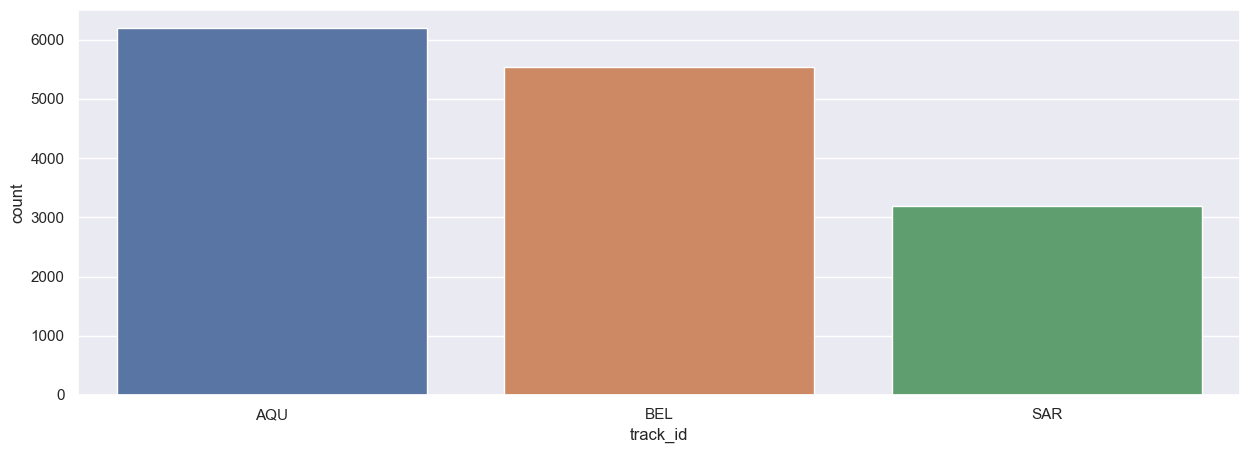

In [36]:
sns.countplot(data = df_start, x = 'track_id')
plt.show()

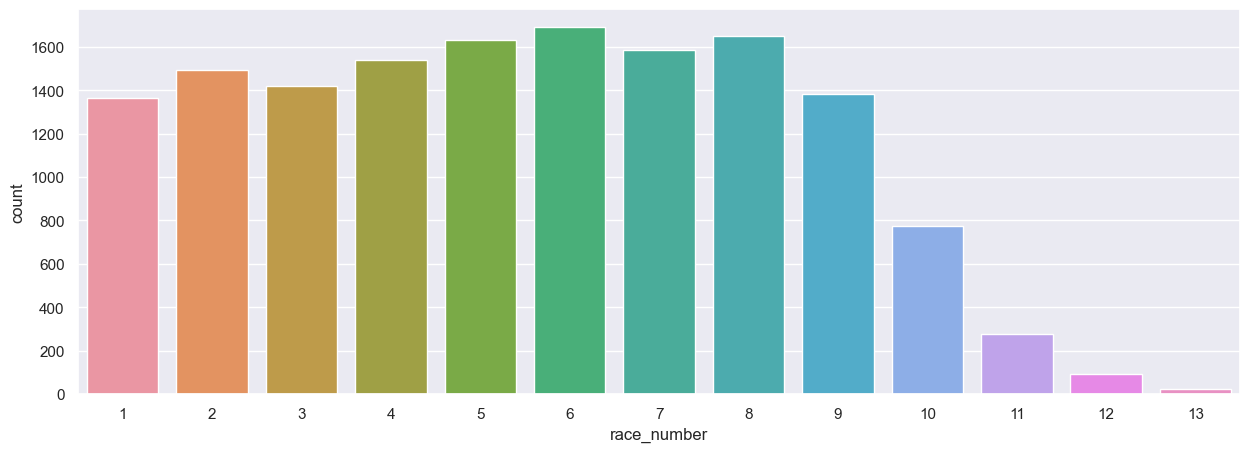

In [37]:
sns.countplot(data = df_start, x = 'race_number')
plt.show()

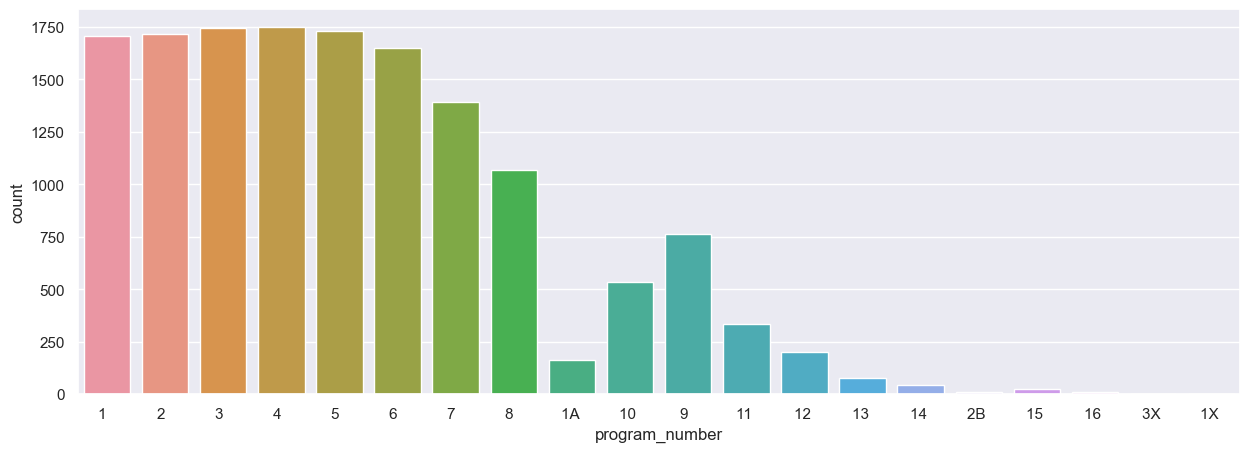

In [38]:
sns.countplot(data = df_start, x = 'program_number')
plt.show()

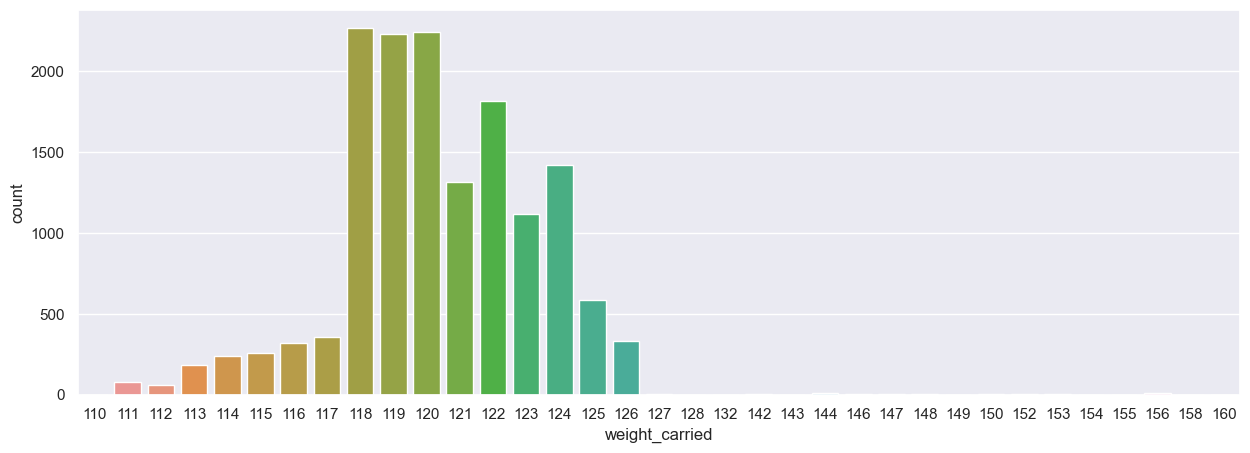

In [39]:
sns.countplot(data = df_start, x = 'weight_carried')
plt.show()

In [40]:
df_start.describe()

,race_number,weight_carried,odds,position_at_finish
count,14915.000000,14915.000000,14915.000000,14915.000000
mean,5.494200,120.454040,1483.496480,4.486088
std,2.826058,3.522007,1956.137156,2.569144
min,1.000000,110.000000,0.000000,1.000000
25%,3.000000,118.000000,335.000000,2.000000
50%,6.000000,120.000000,730.000000,4.000000
75%,8.000000,122.000000,1740.000000,6.000000
max,13.000000,160.000000,19100.000000,14.000000


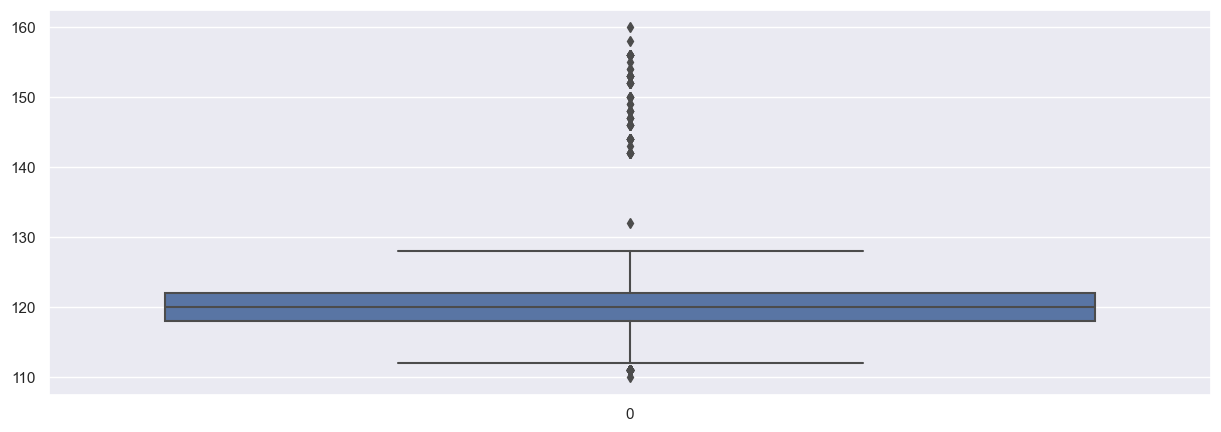

In [41]:
sns.boxplot(df_start['weight_carried']);

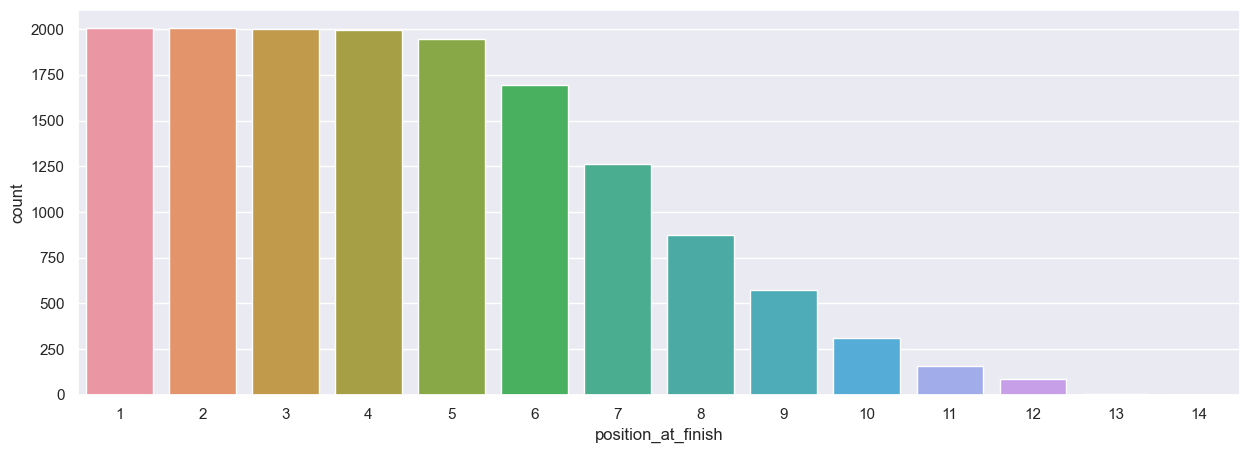

In [42]:
sns.countplot(data = df_start, x = 'position_at_finish')
plt.show()

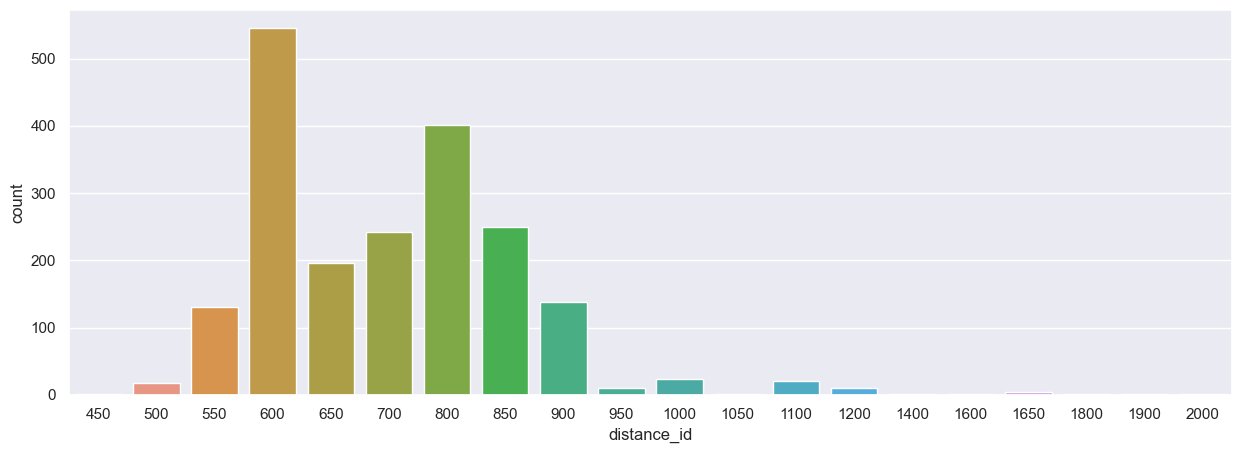

In [43]:
sns.countplot(data = df_race, x = 'distance_id')
plt.show()

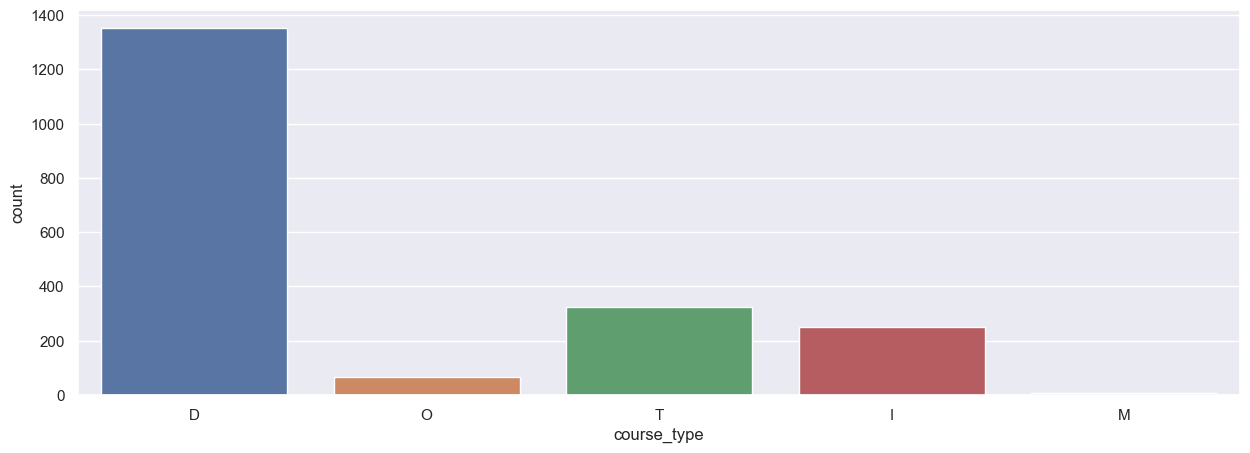

In [44]:
sns.countplot(data = df_race, x = 'course_type')
plt.show()

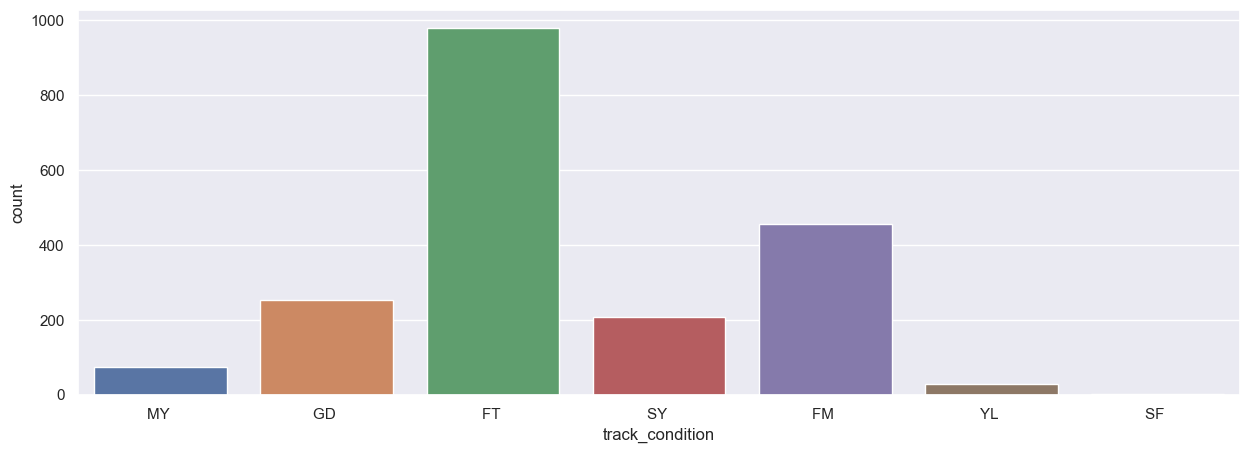

In [45]:
sns.countplot(data = df_race, x = 'track_condition')
plt.show()

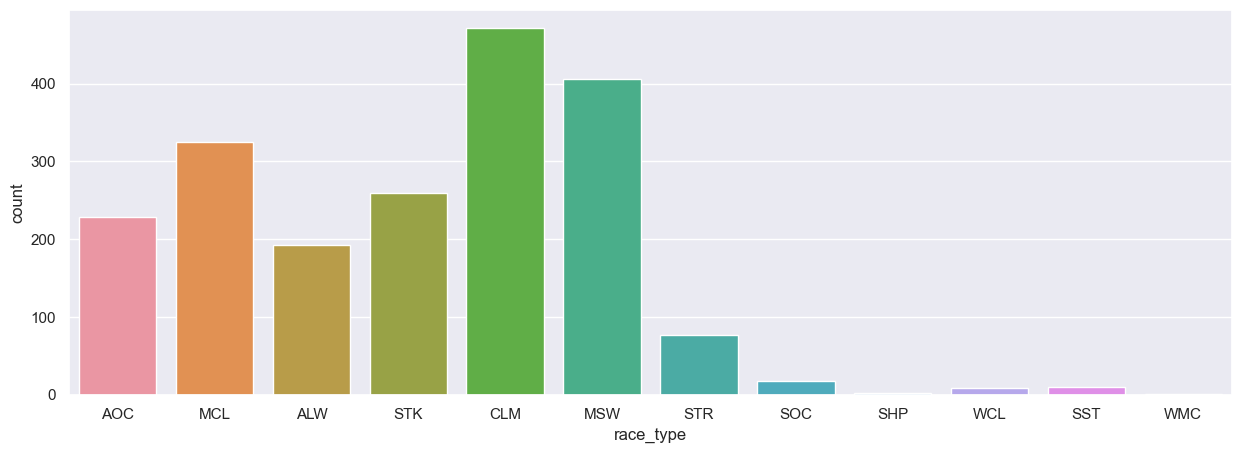

In [46]:
sns.countplot(data = df_race, x = 'race_type')
plt.show()

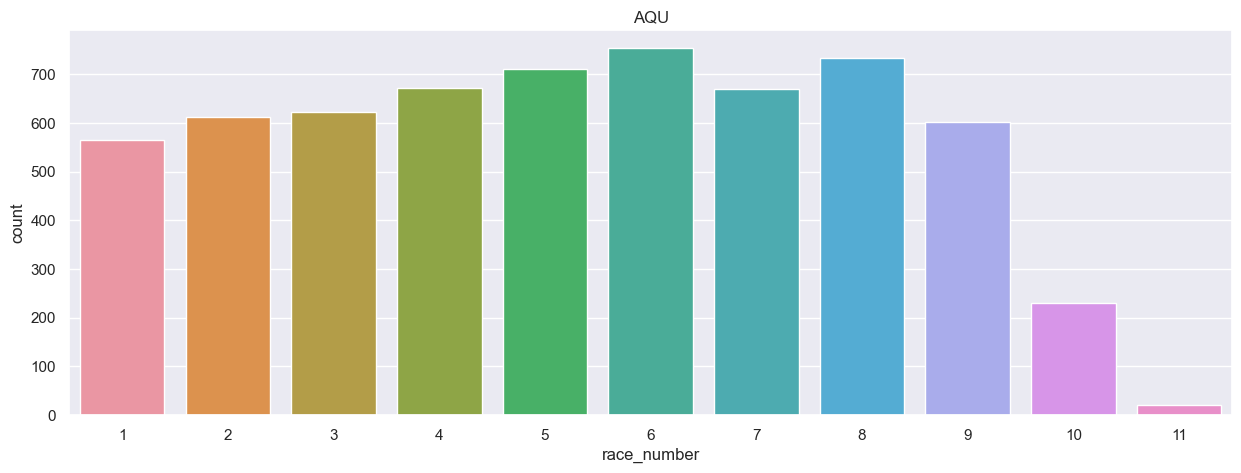

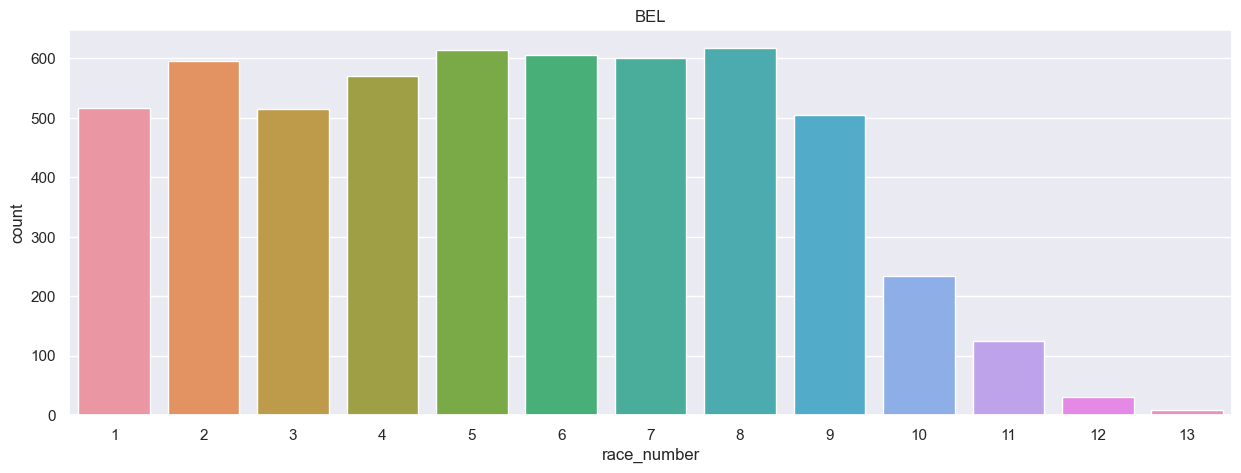

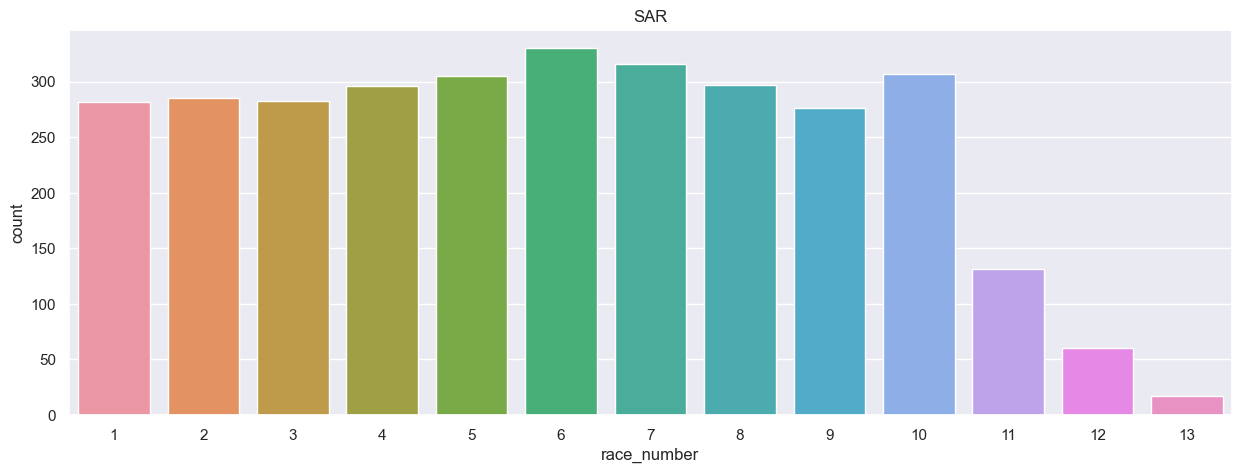

In [47]:
for t in df_start.track_id.unique():
    sns.countplot(data = df_start[df_start.track_id == t], x='race_number')
    plt.title(t)
    plt.show()

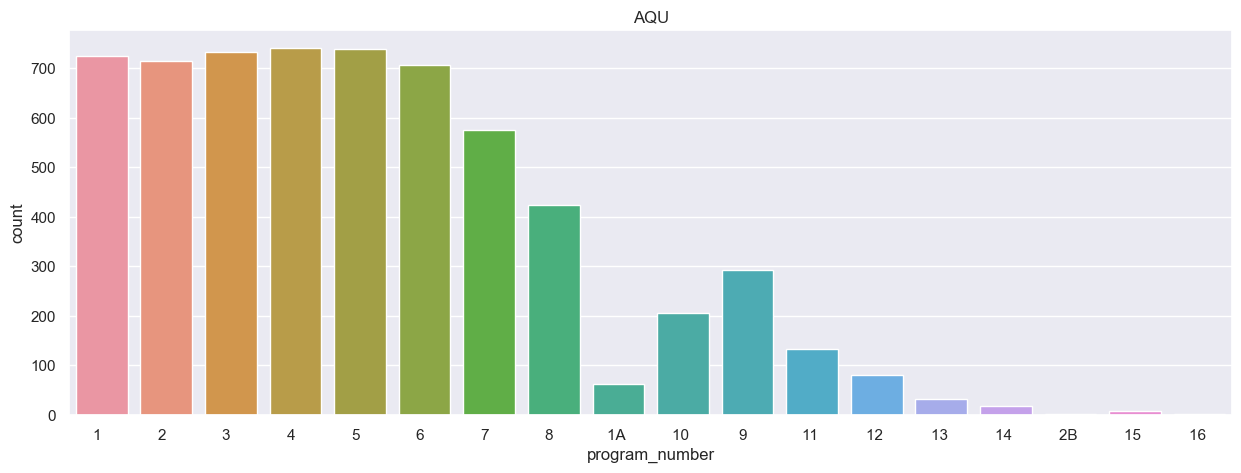

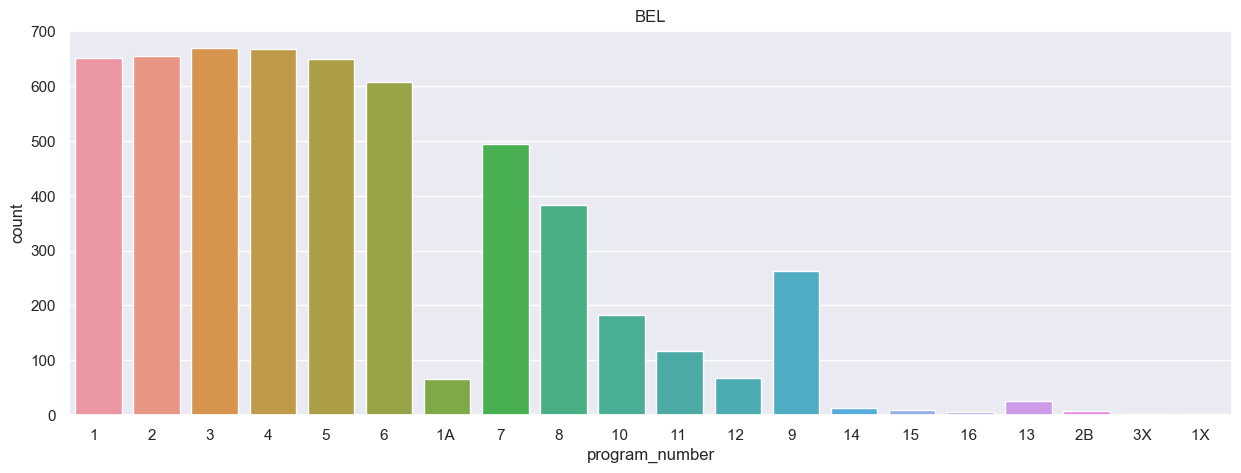

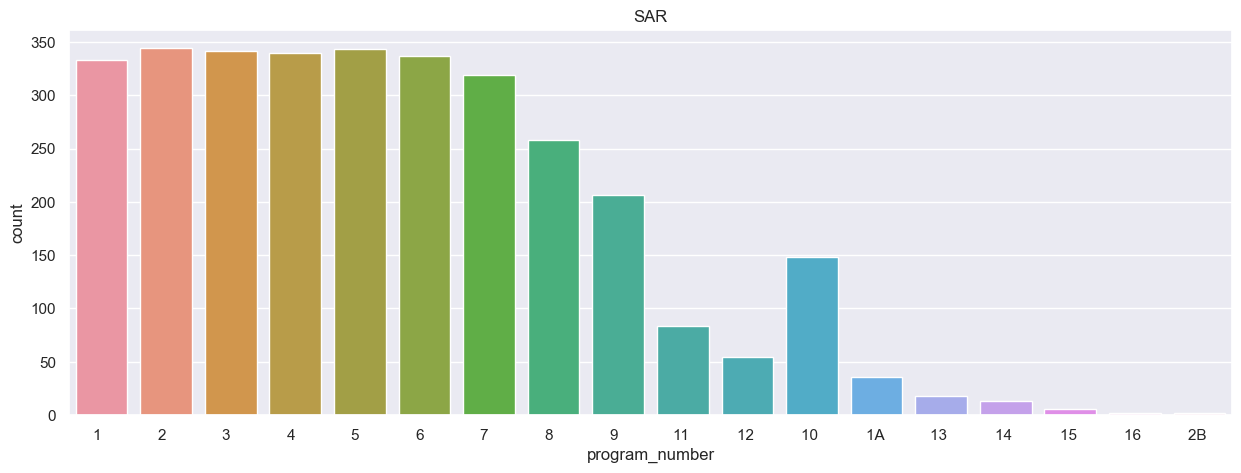

In [48]:
for t in df_start.track_id.unique():
    sns.countplot(data = df_start[df_start.track_id == t], x='program_number')
    plt.title(t)
    plt.show()

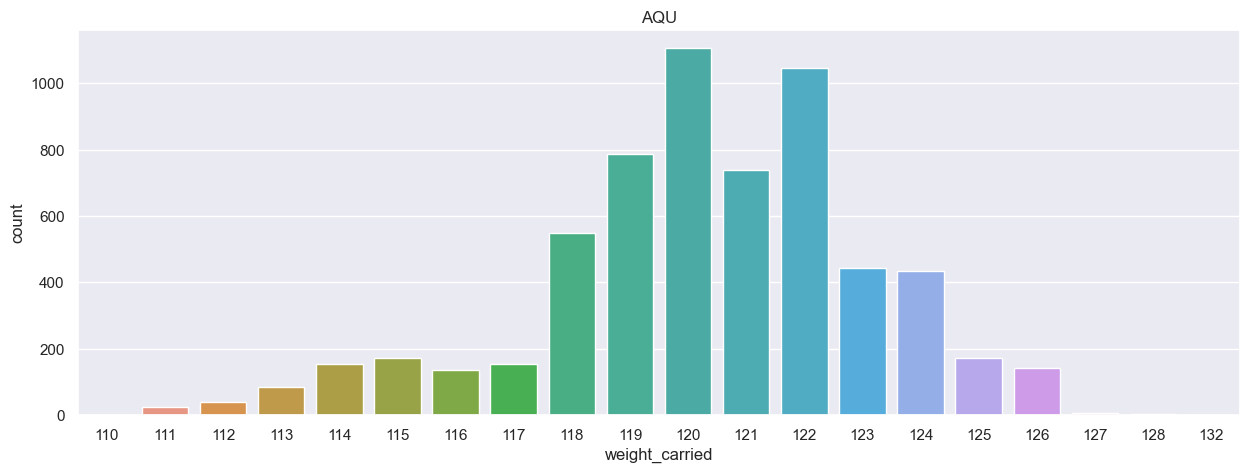

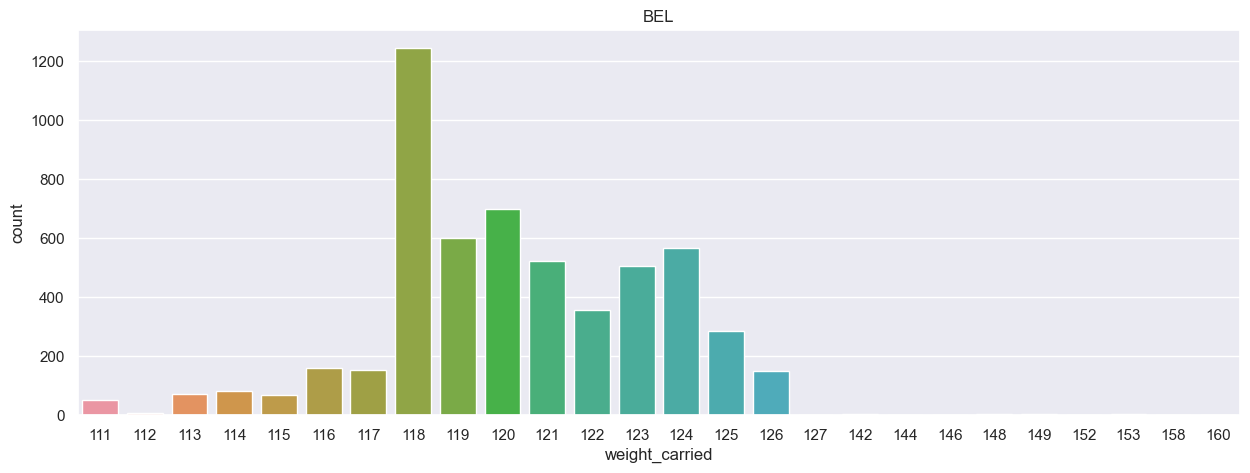

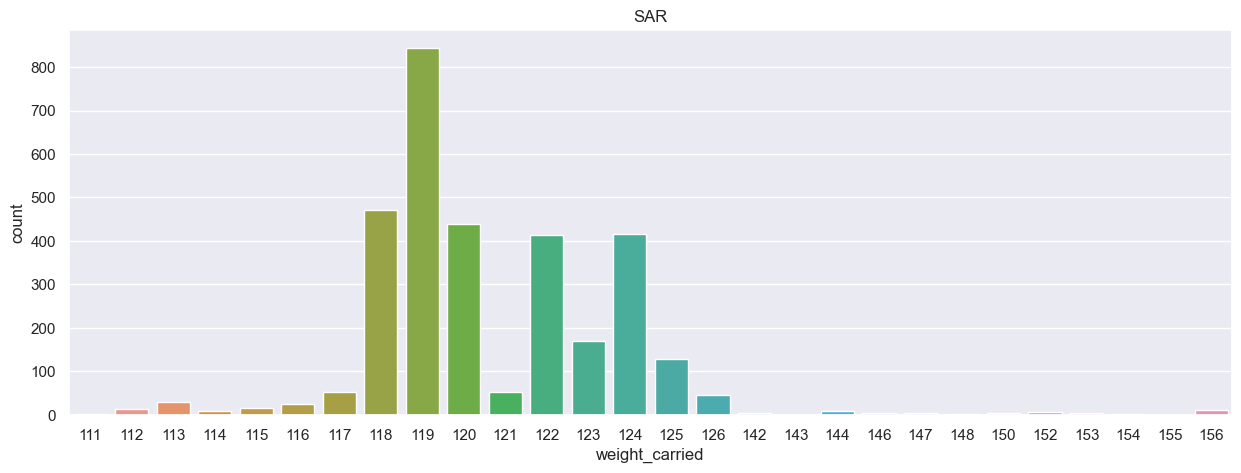

In [49]:
for t in df_start.track_id.unique():
    sns.countplot(data = df_start[df_start.track_id == t], x='weight_carried')
    plt.title(t)
    plt.show()

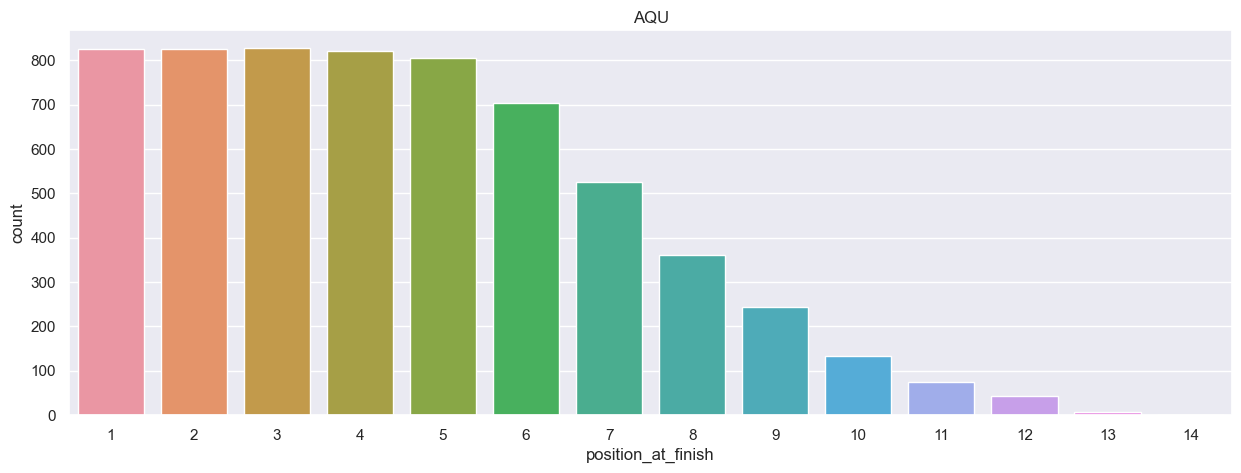

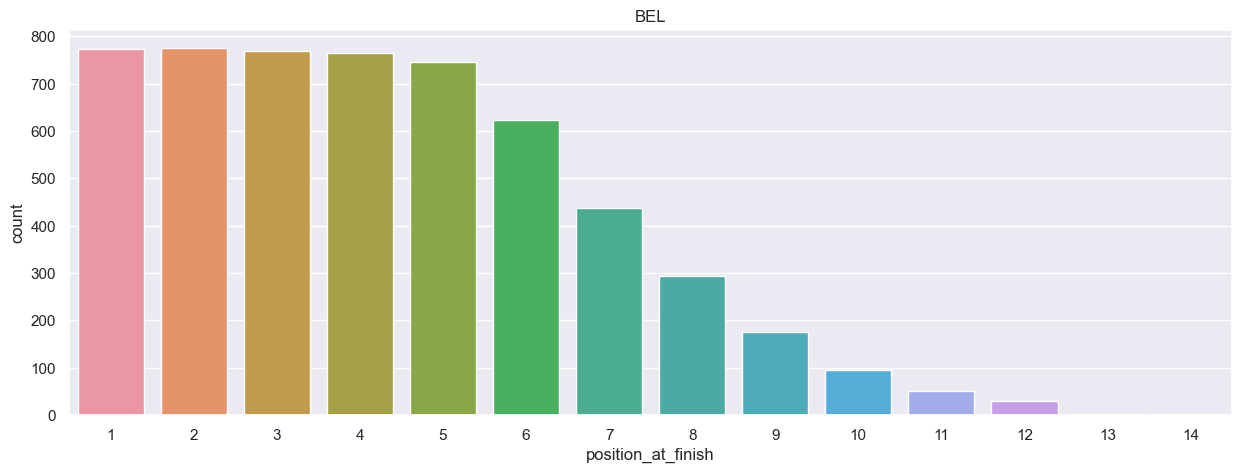

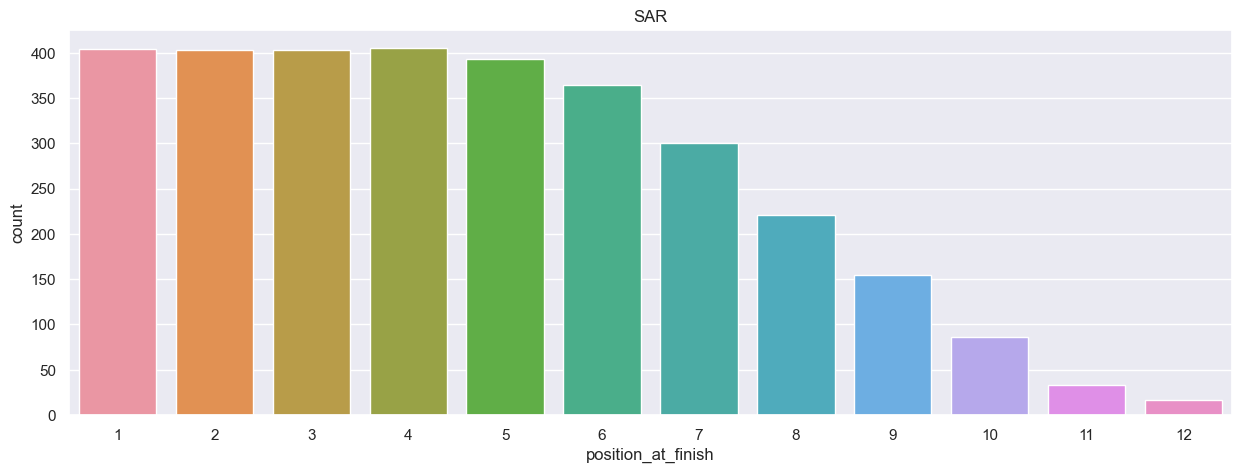

In [50]:
for t in df_start.track_id.unique():
    sns.countplot(data = df_start[df_start.track_id == t], x='position_at_finish')
    plt.title(t)
    plt.show()

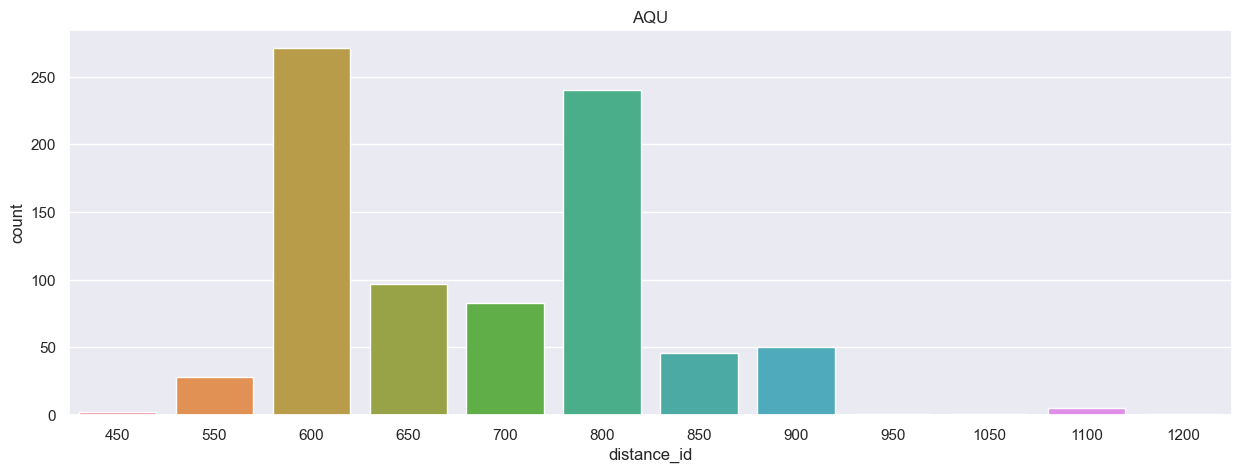

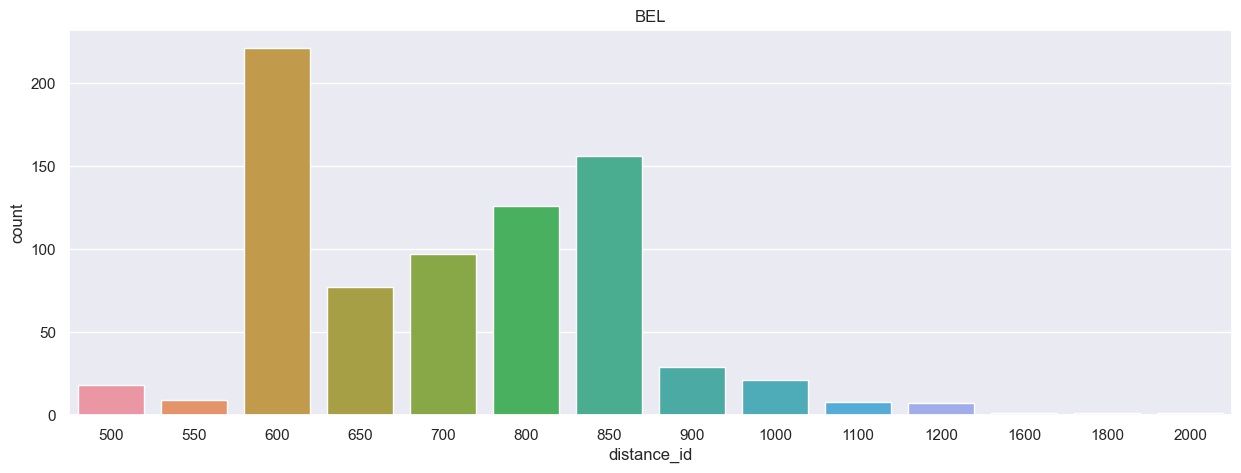

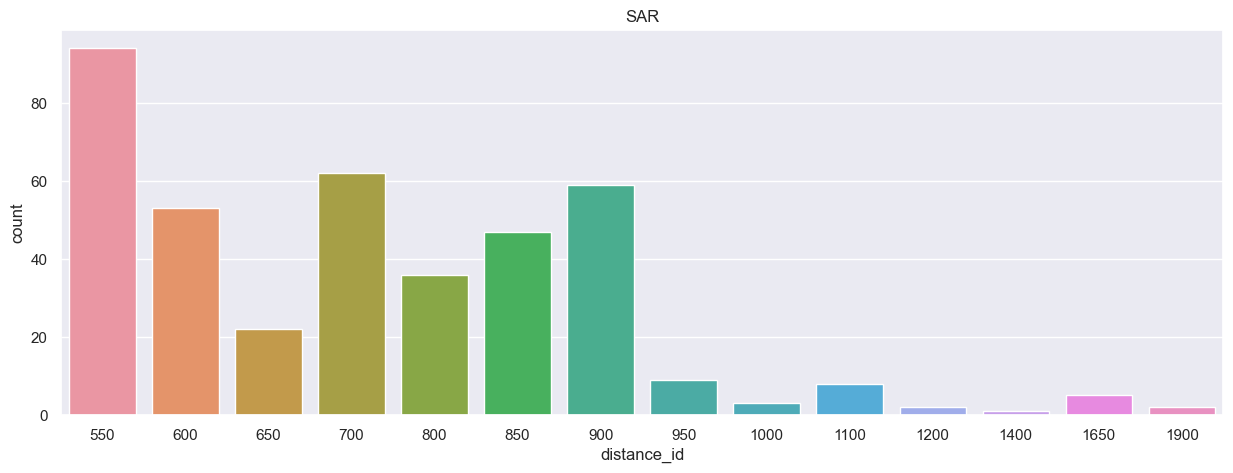

In [51]:
for t in df_race.track_id.unique():
    sns.countplot(data = df_race[df_race.track_id == t], x='distance_id')
    plt.title(t)
    plt.show()

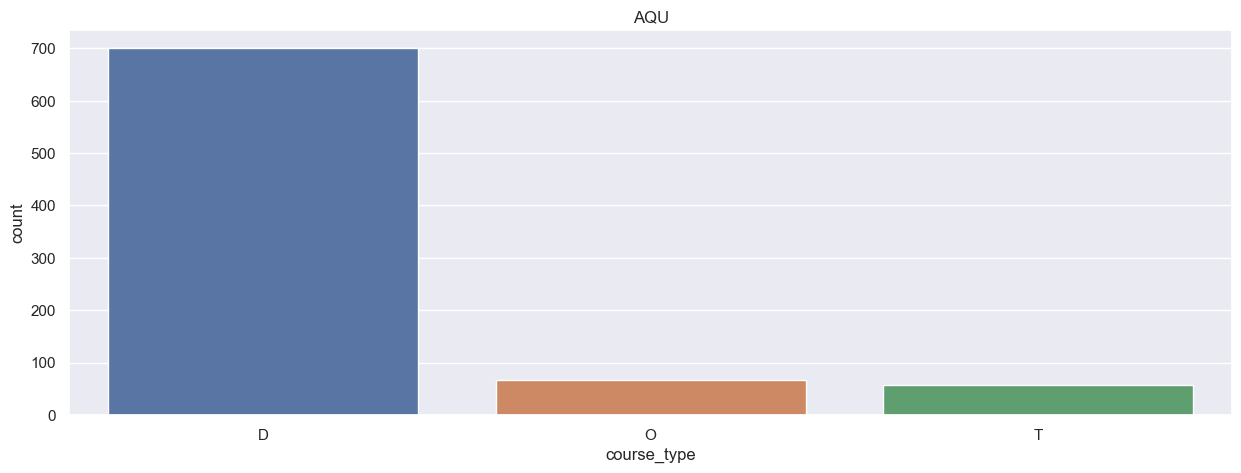

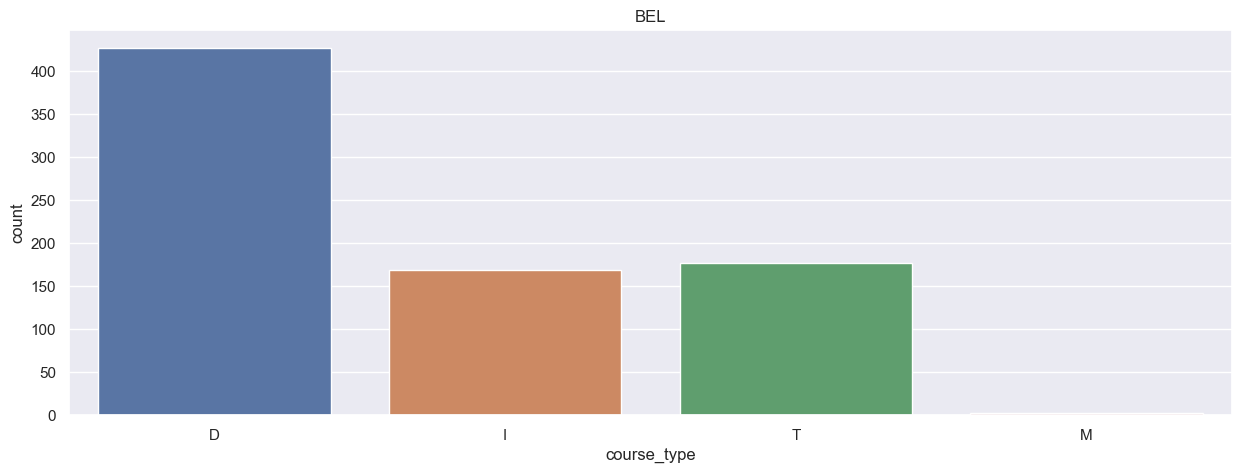

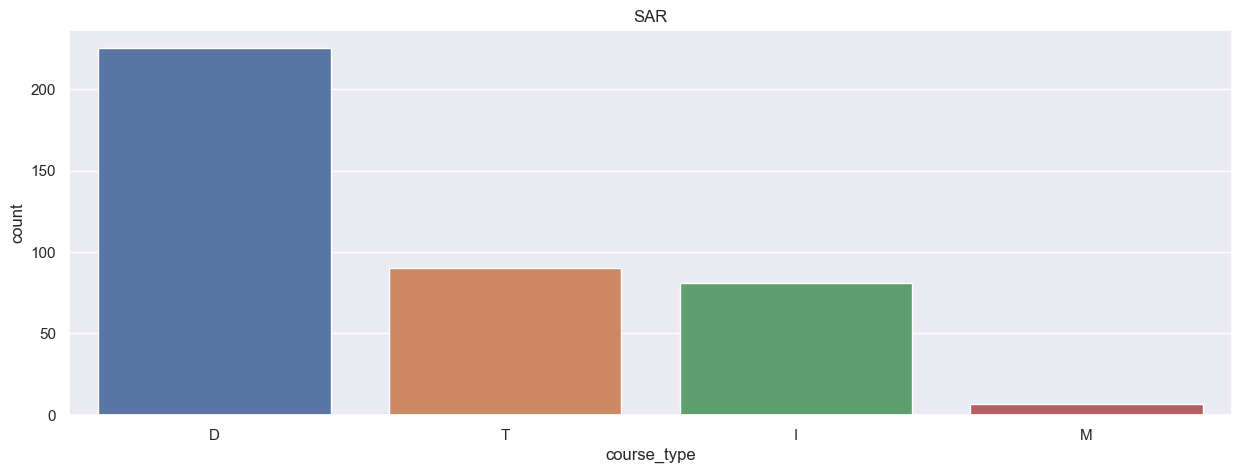

In [52]:
for t in df_race.track_id.unique():
    sns.countplot(data = df_race[df_race.track_id == t], x='course_type')
    plt.title(t)
    plt.show()

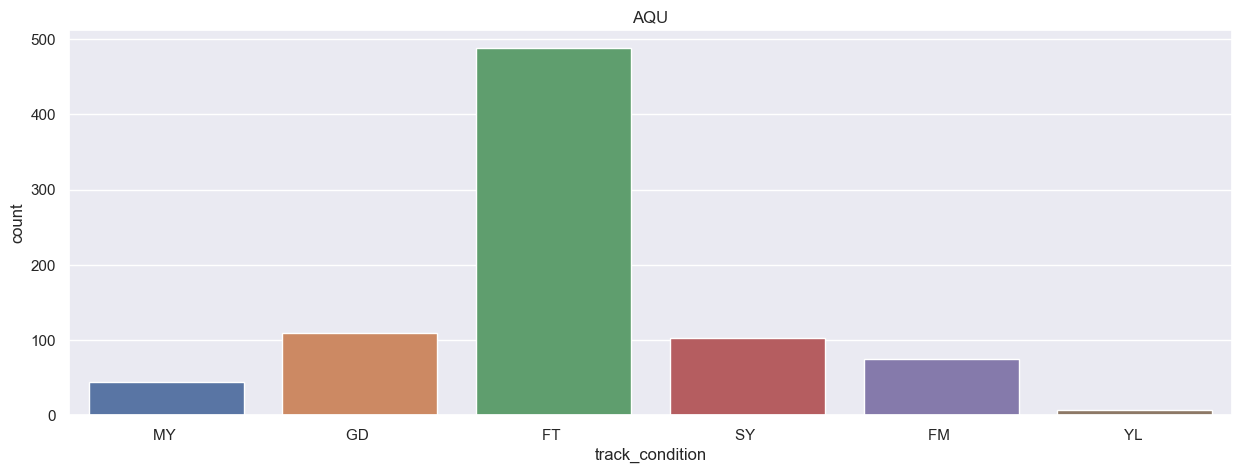

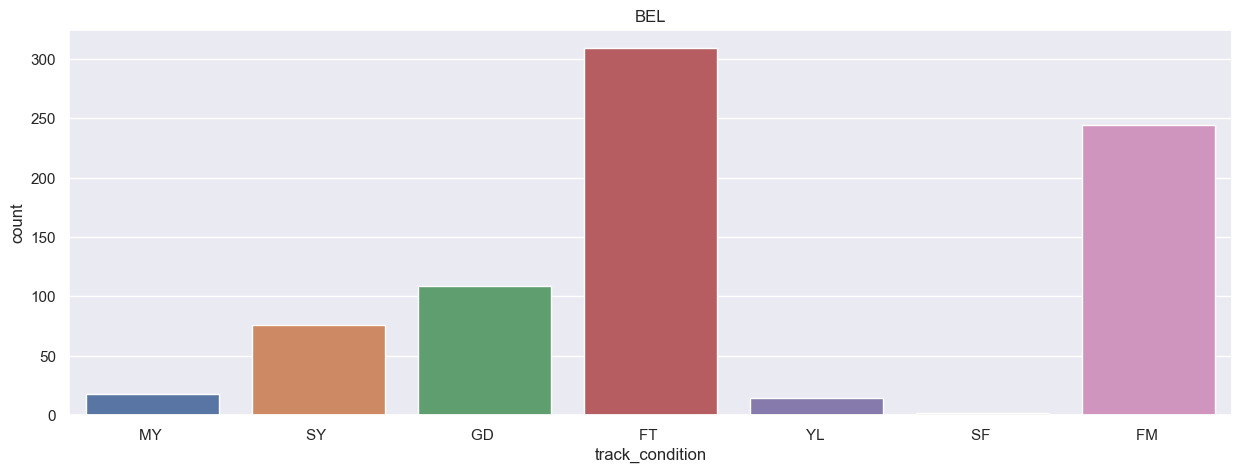

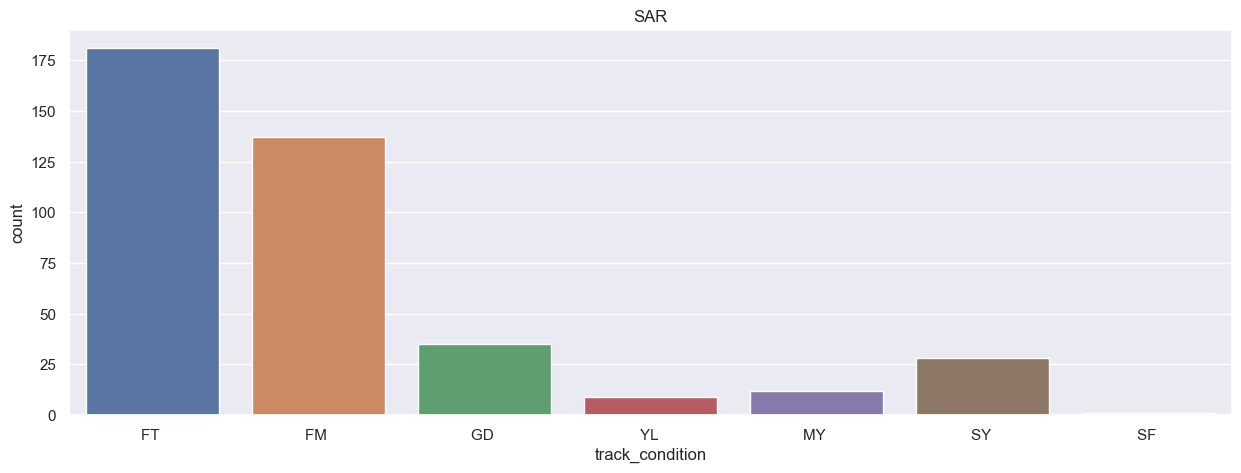

In [53]:
for t in df_race.track_id.unique():
    sns.countplot(data = df_race[df_race.track_id == t], x='track_condition')
    plt.title(t)
    plt.show()

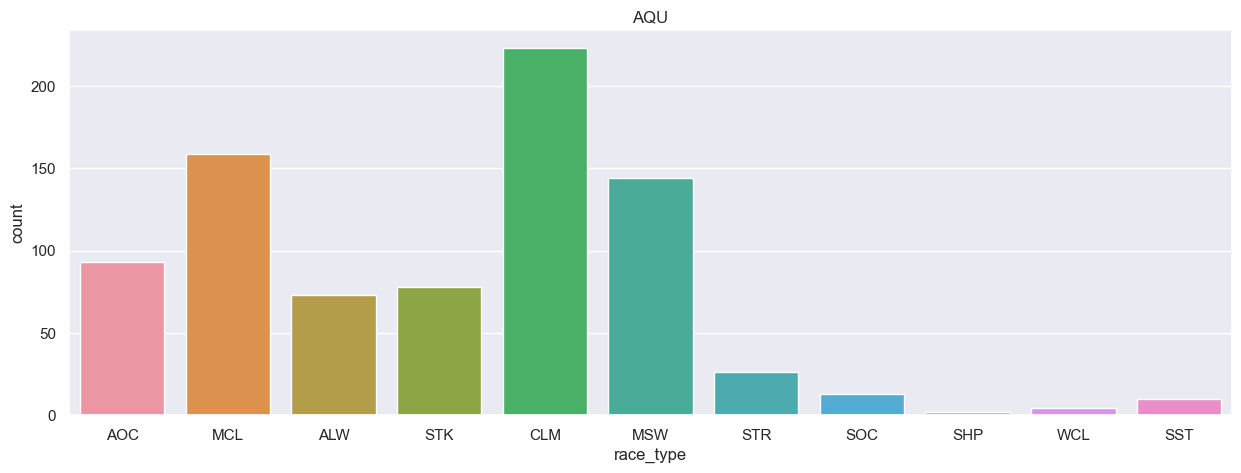

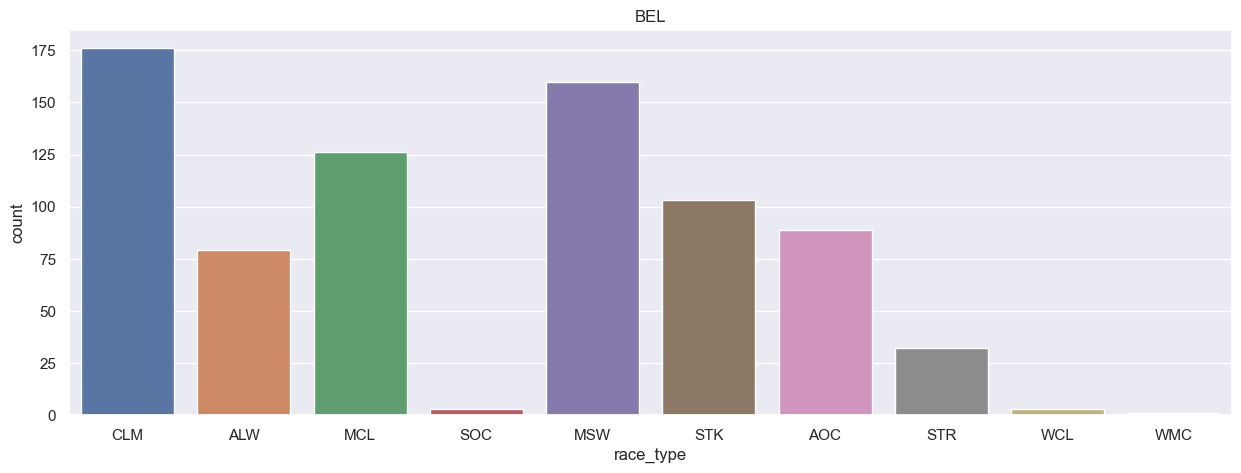

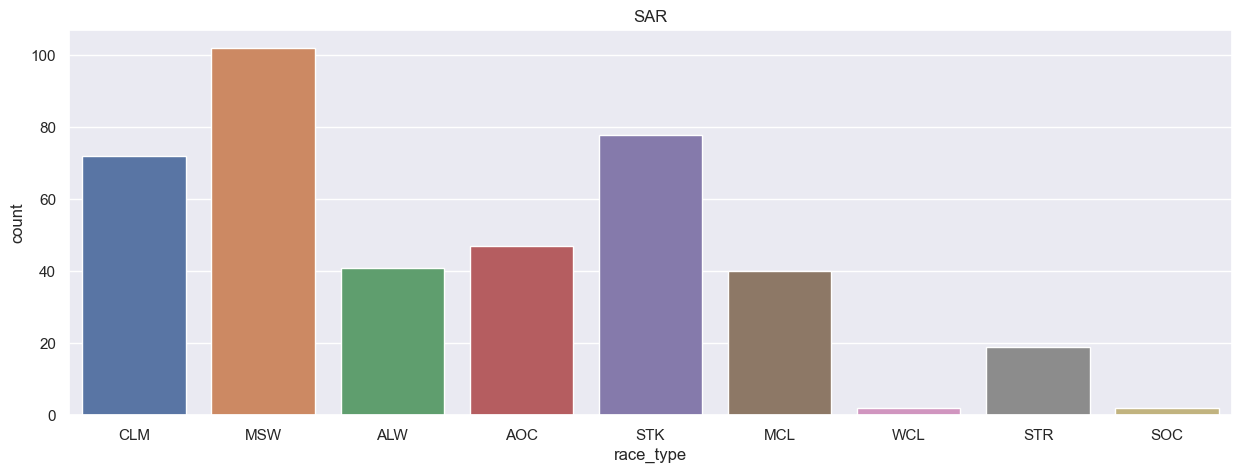

In [54]:
for t in df_race.track_id.unique():
    sns.countplot(data = df_race[df_race.track_id == t], x='race_type')
    plt.title(t)
    plt.show()

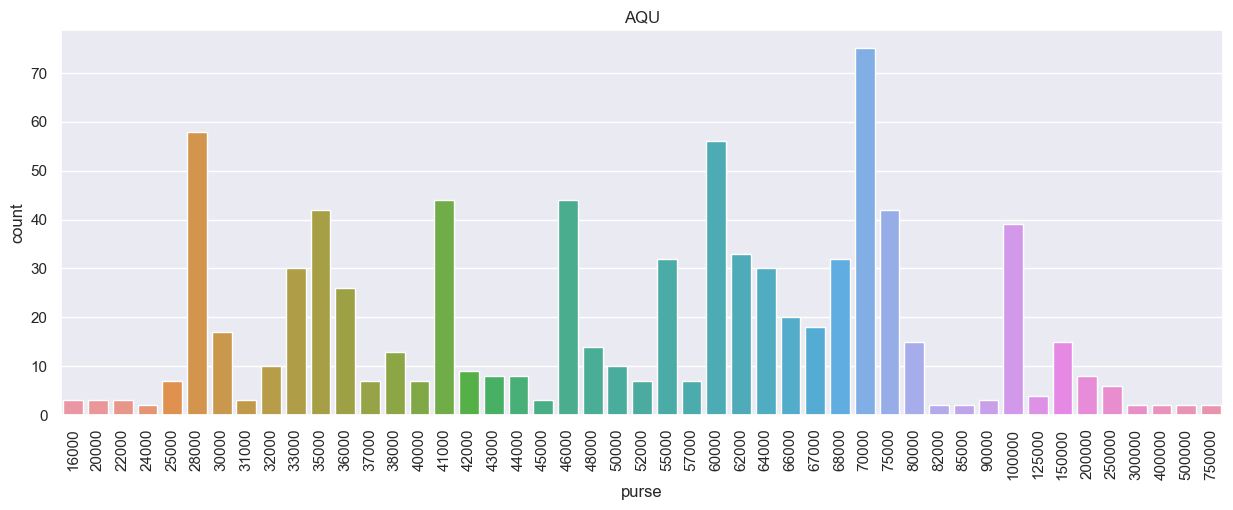

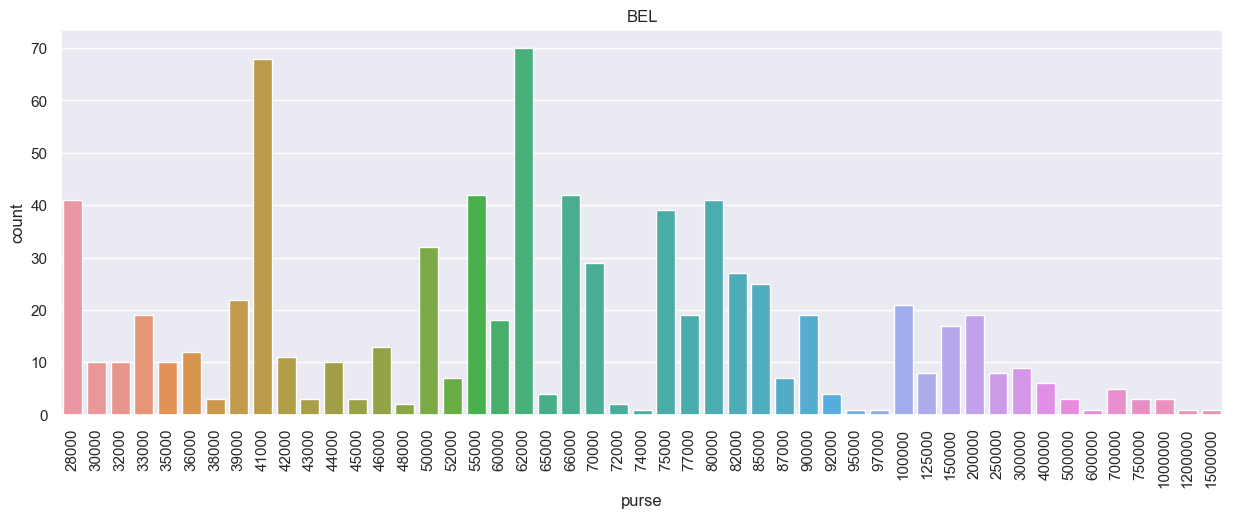

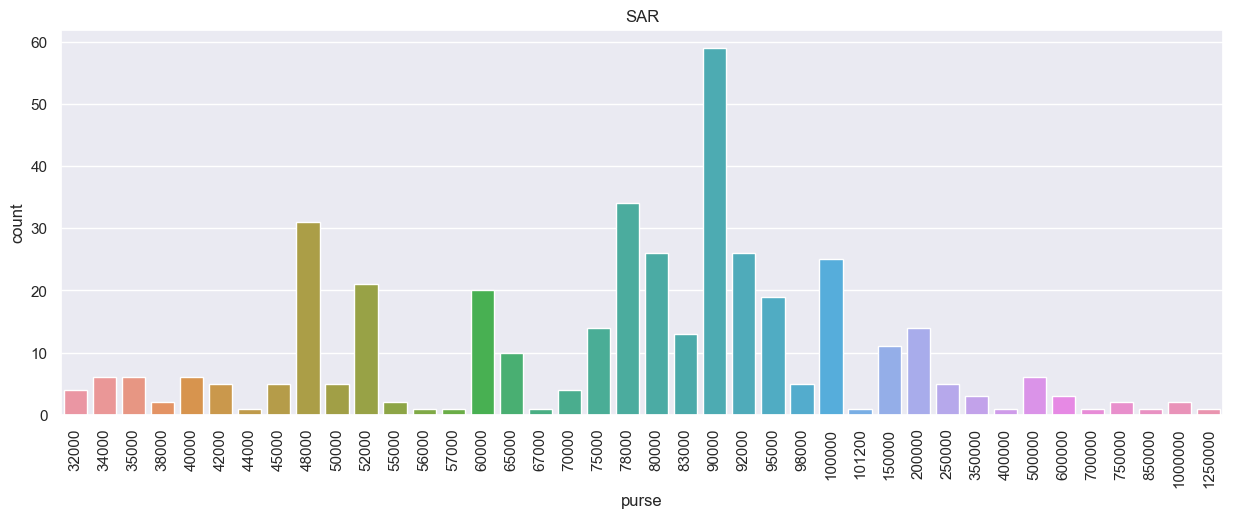

In [55]:
for t in df_race.track_id.unique():
    sns.countplot(data = df_race[df_race.track_id == t], x='purse')
    plt.title(t)
    plt.xticks(rotation=90)
    plt.show()

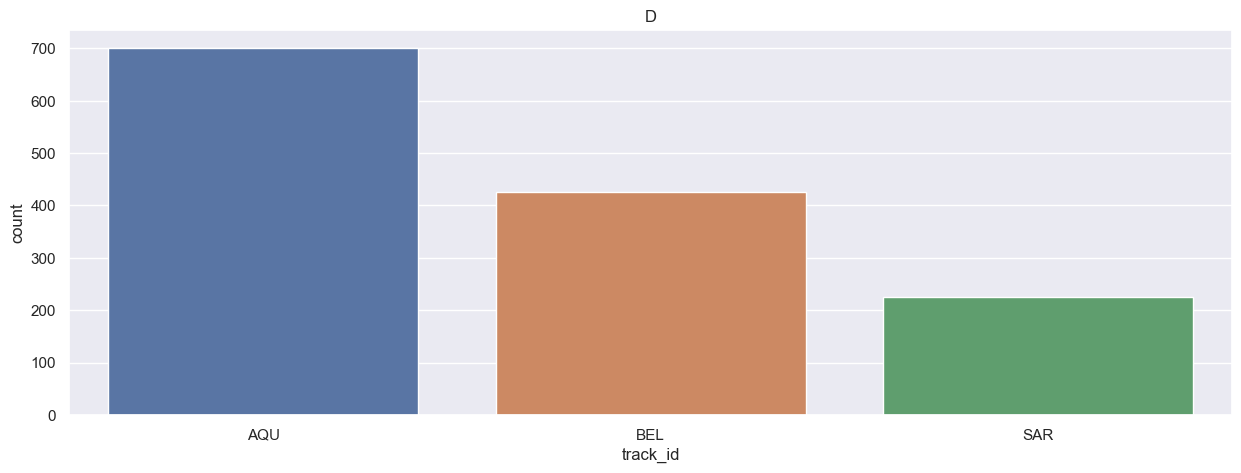

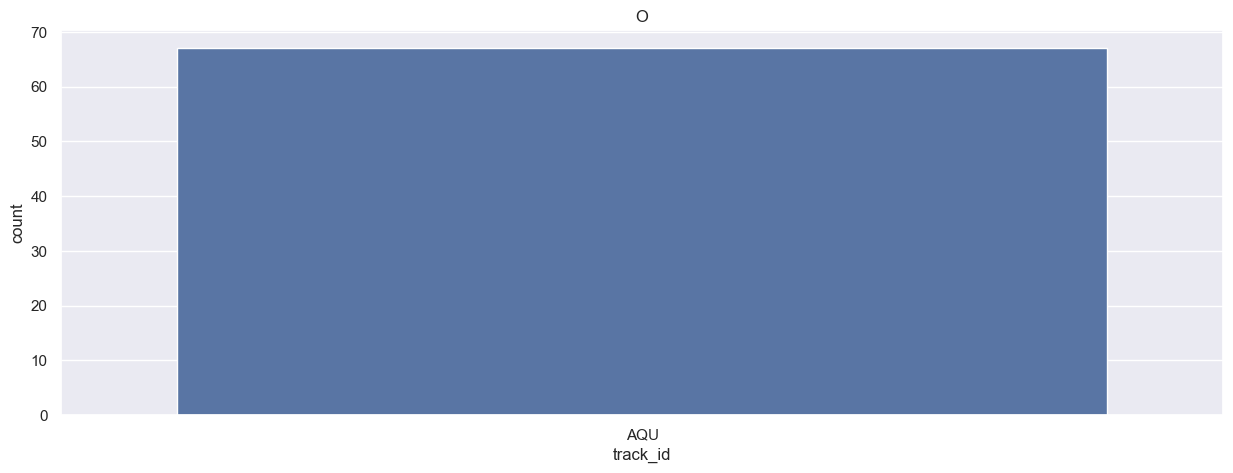

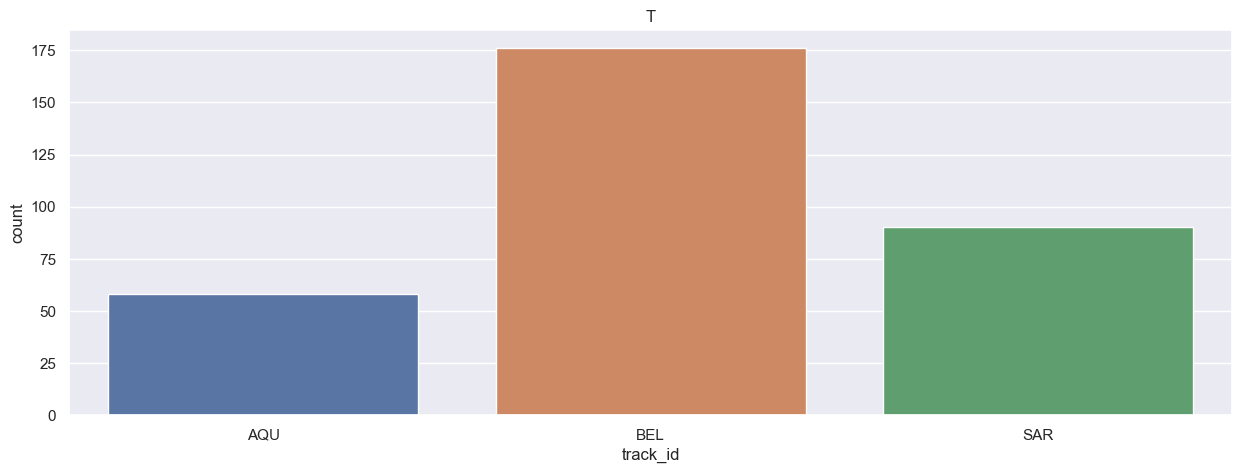

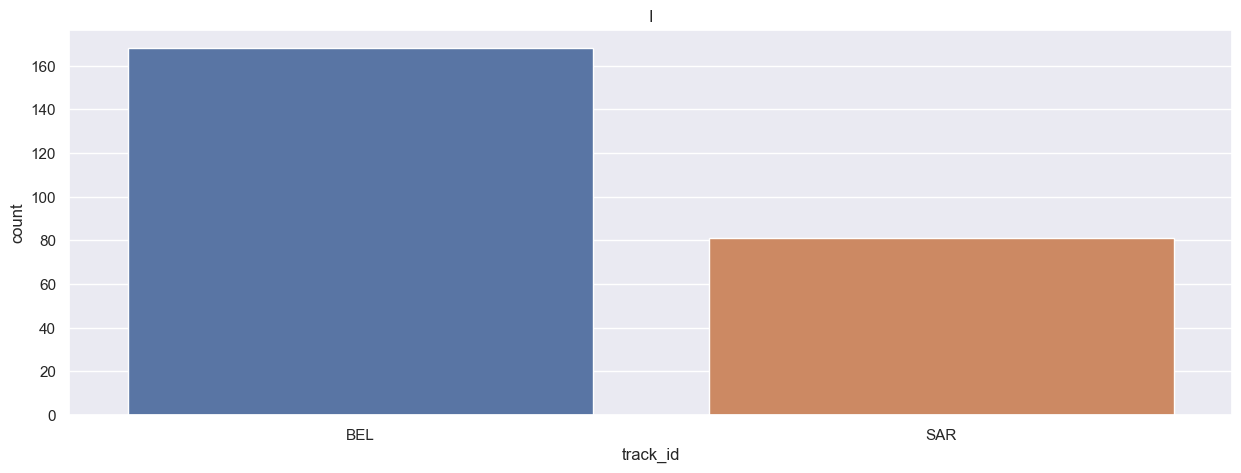

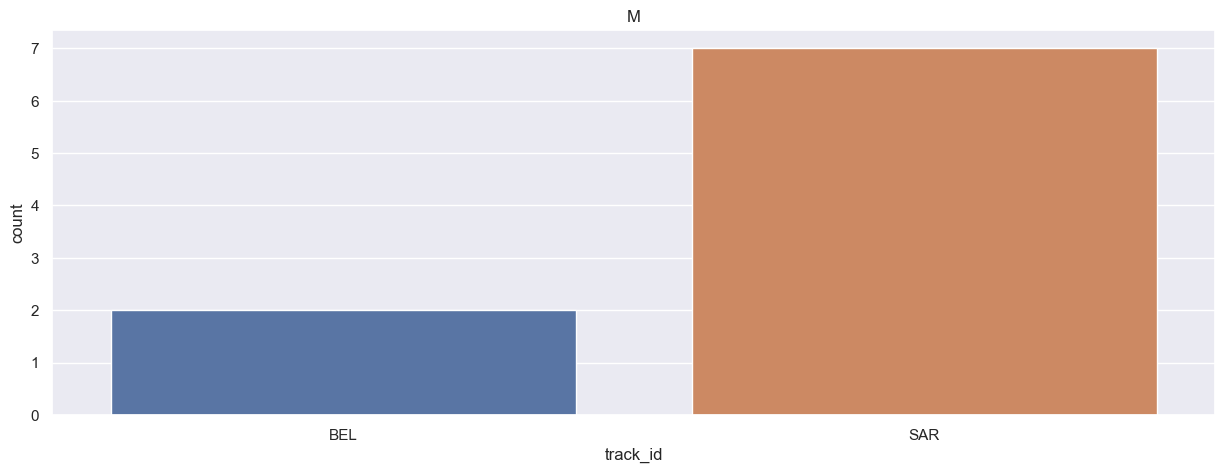

In [56]:
for c in df_race.course_type.unique():
    sns.countplot(data = df_race[df_race.course_type == c], x='track_id')
    plt.title(c)
    plt.show()

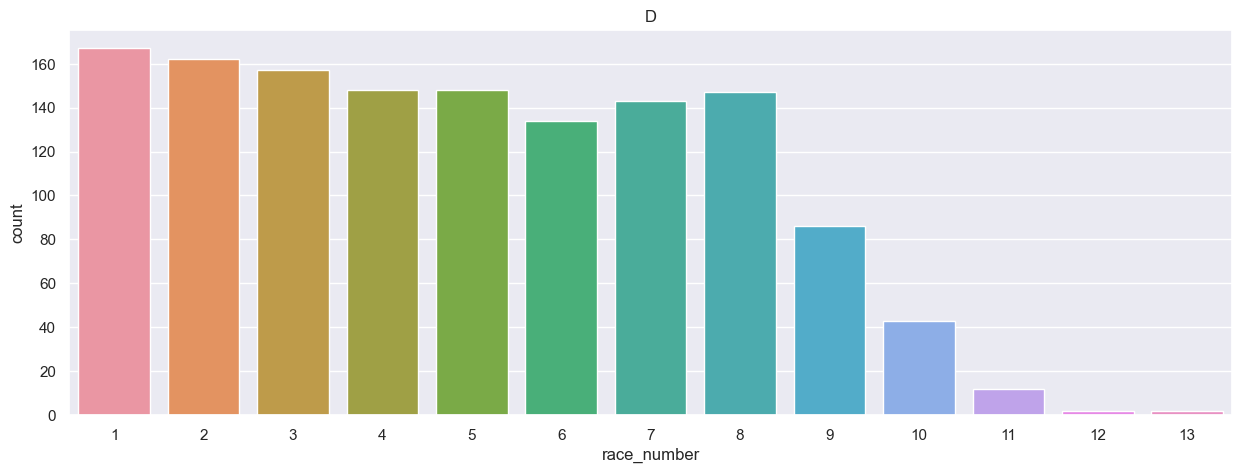

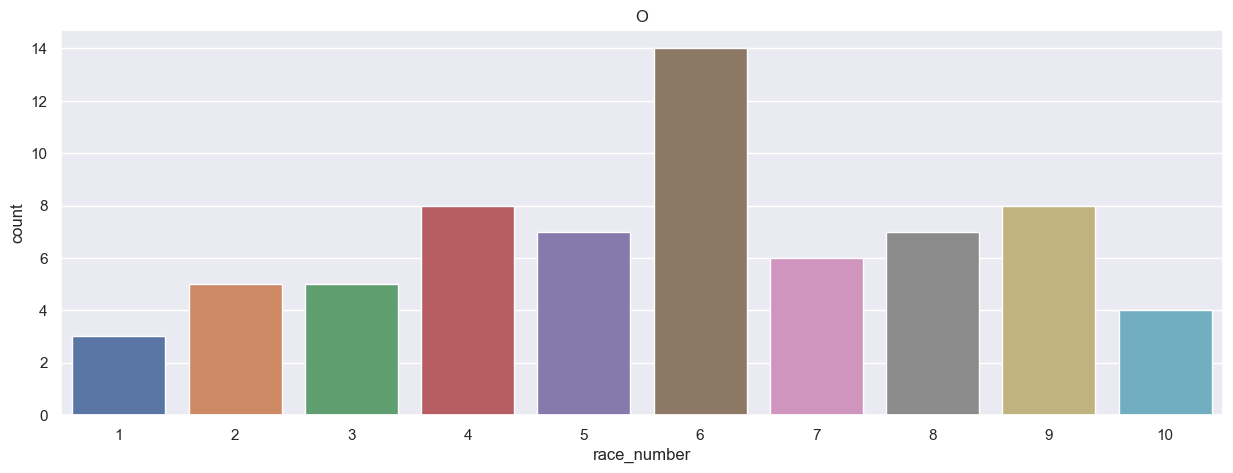

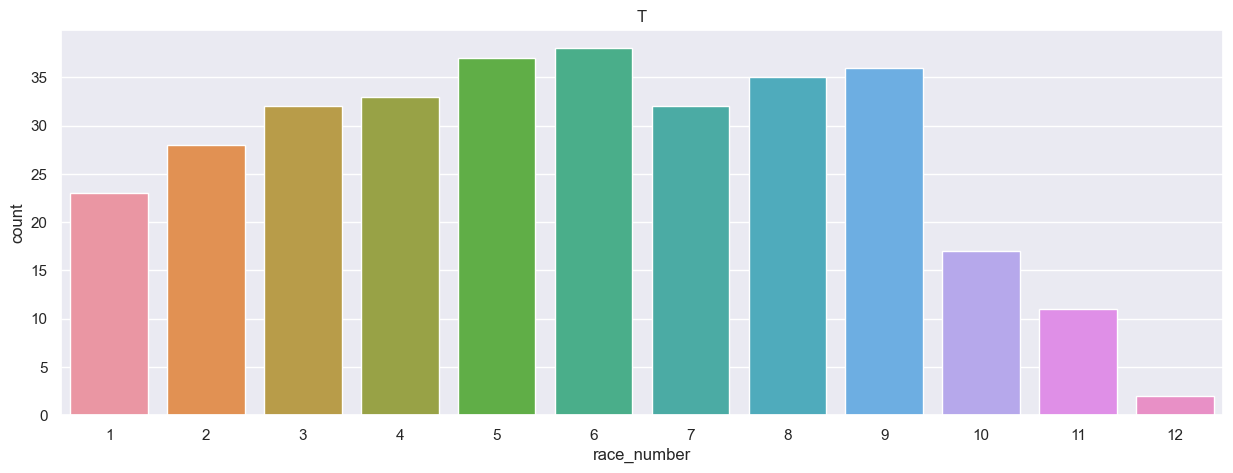

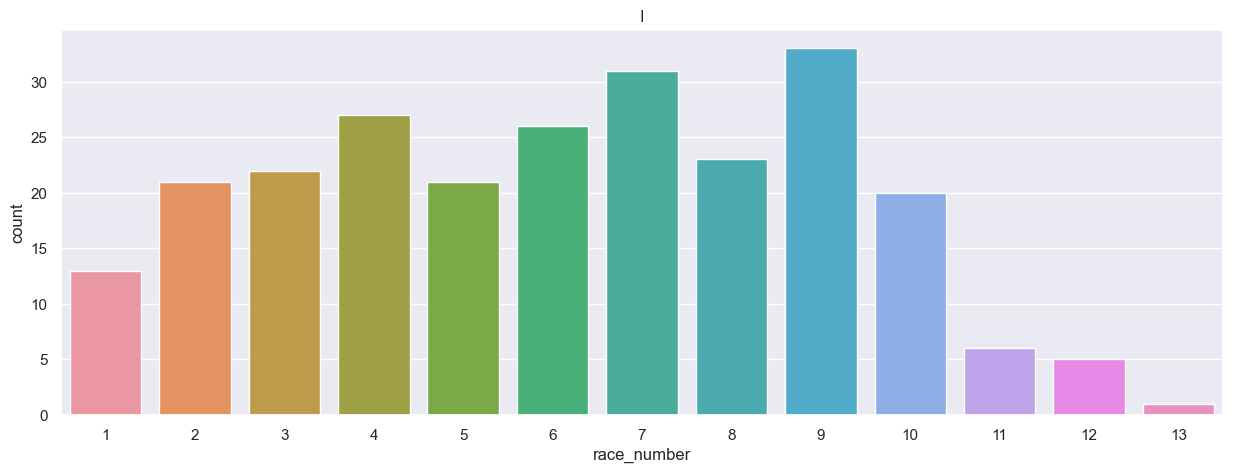

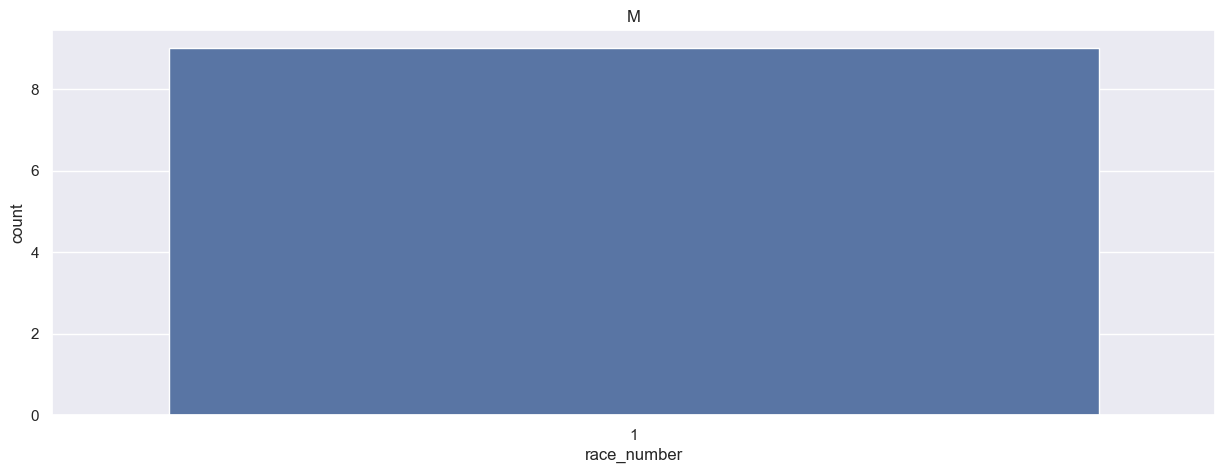

In [57]:
for c in df_race.course_type.unique():
    sns.countplot(data = df_race[df_race.course_type == c], x='race_number')
    plt.title(c)
    plt.show()

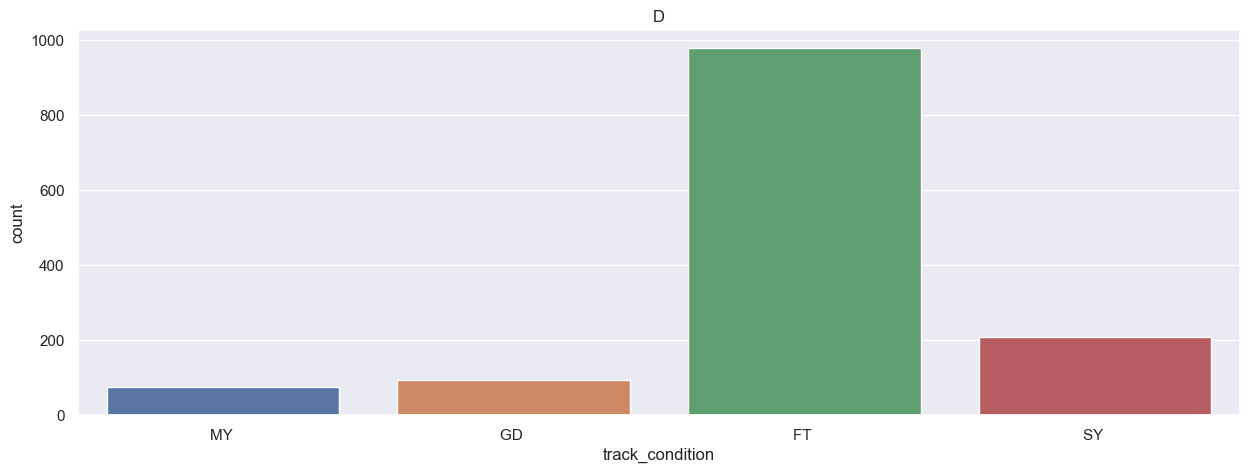

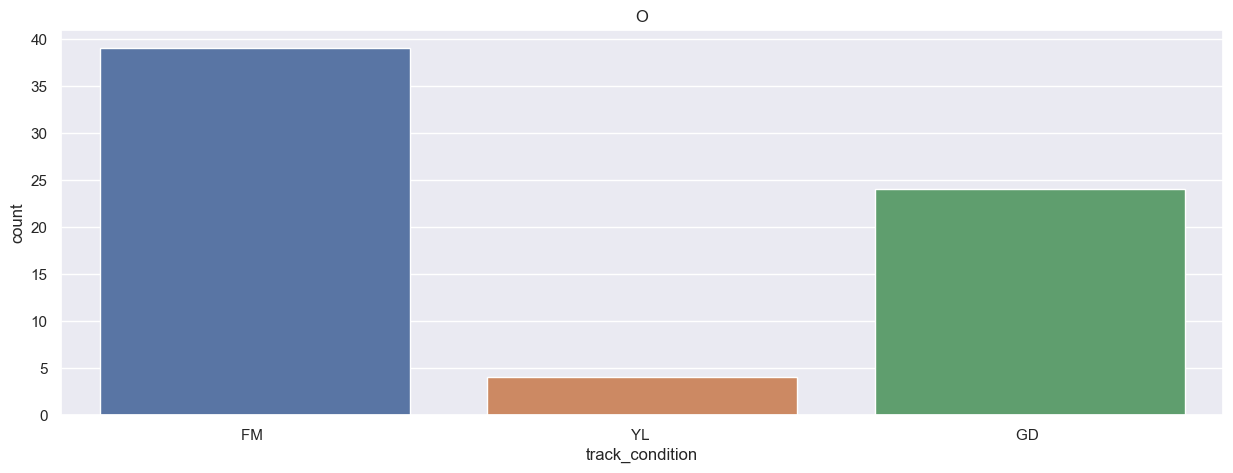

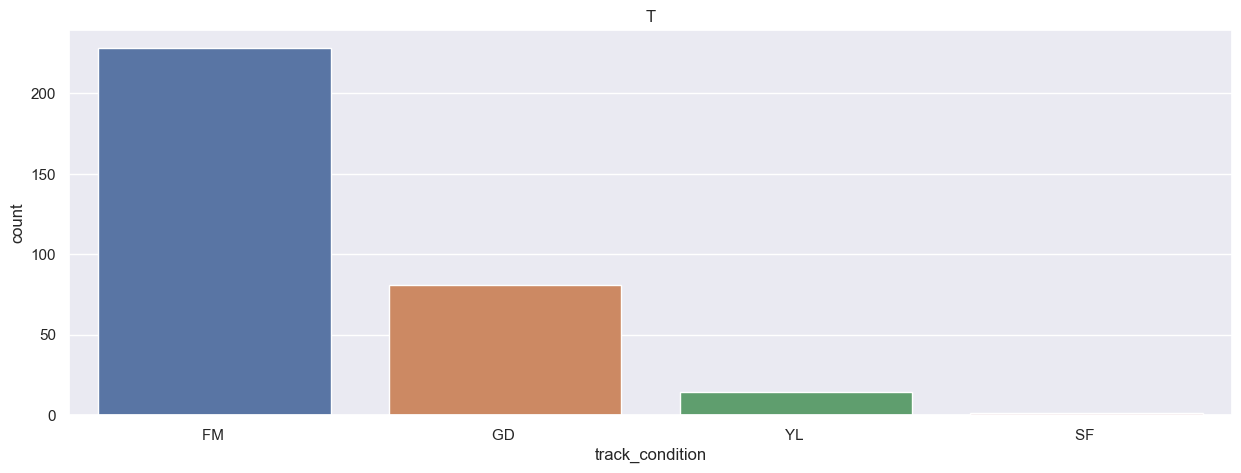

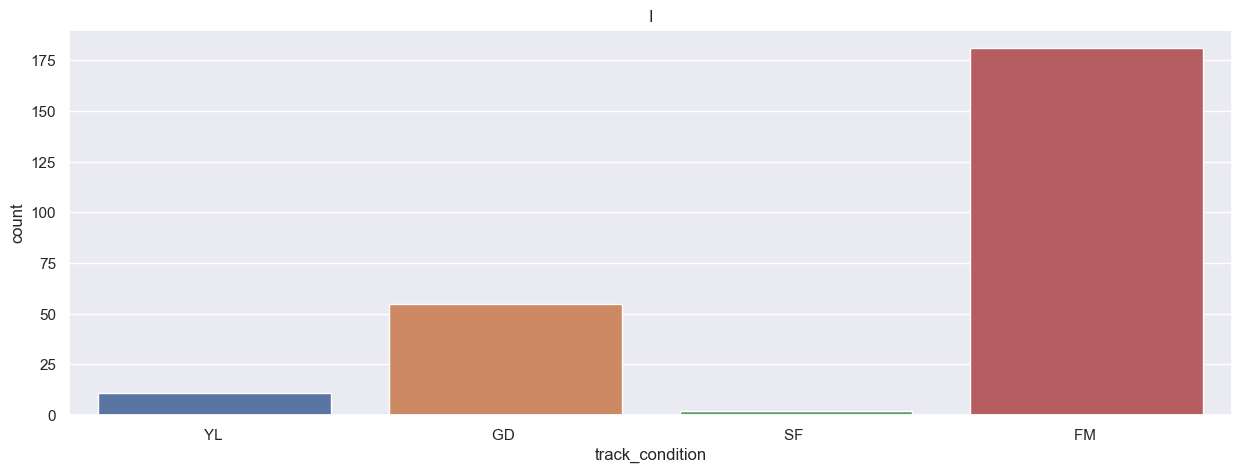

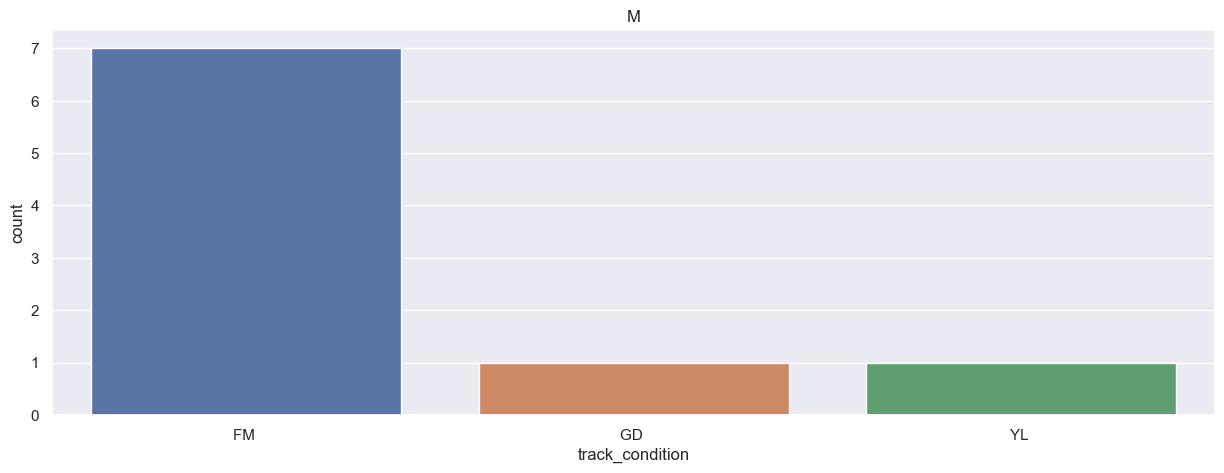

In [58]:
for c in df_race.course_type.unique():
    sns.countplot(data = df_race[df_race.course_type == c], x='track_condition')
    plt.title(c)
    plt.show()

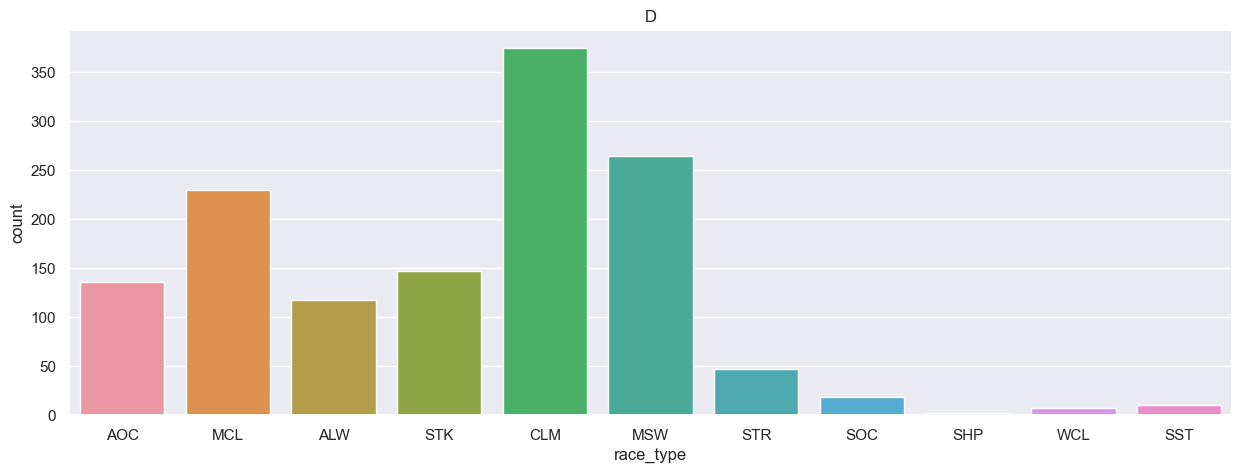

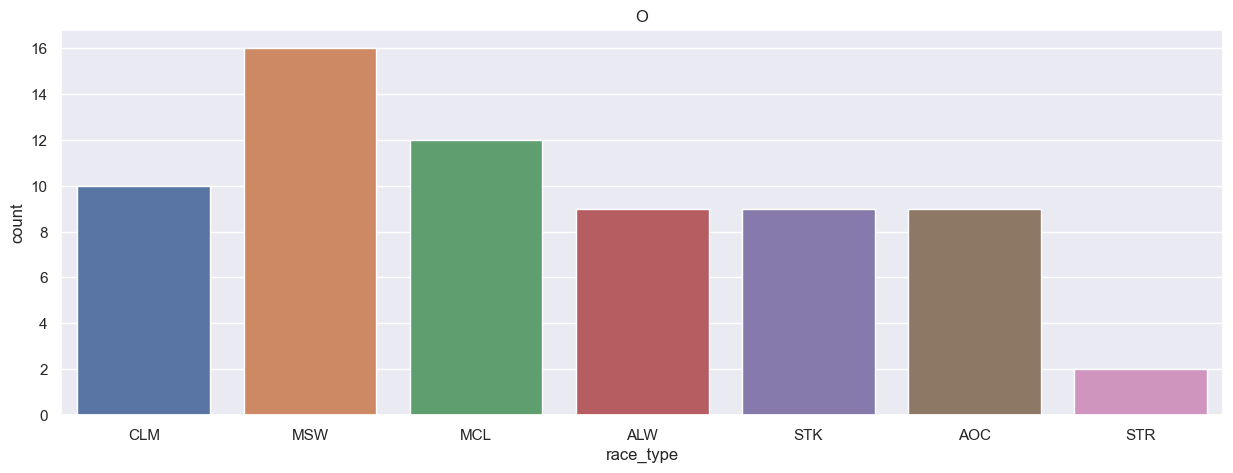

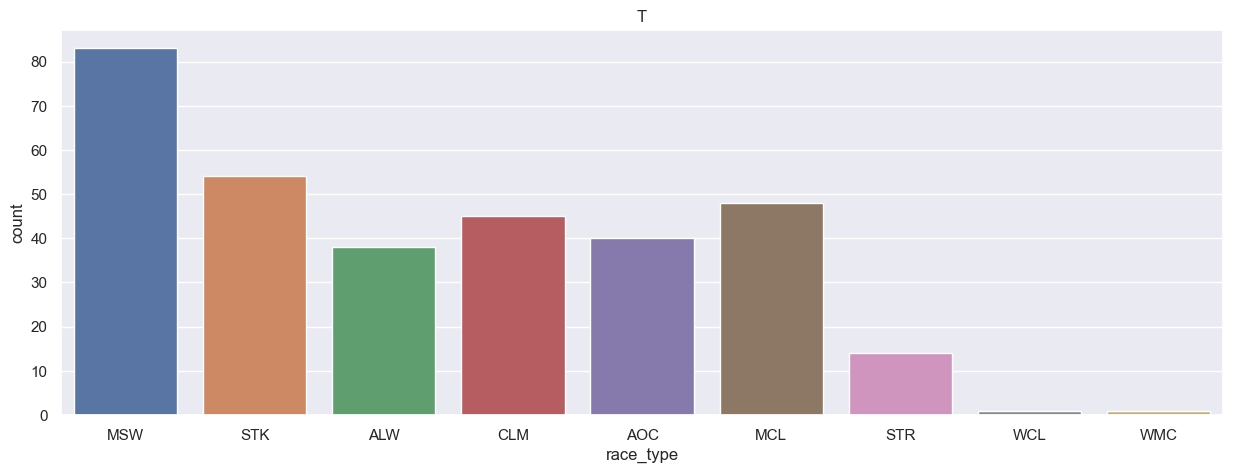

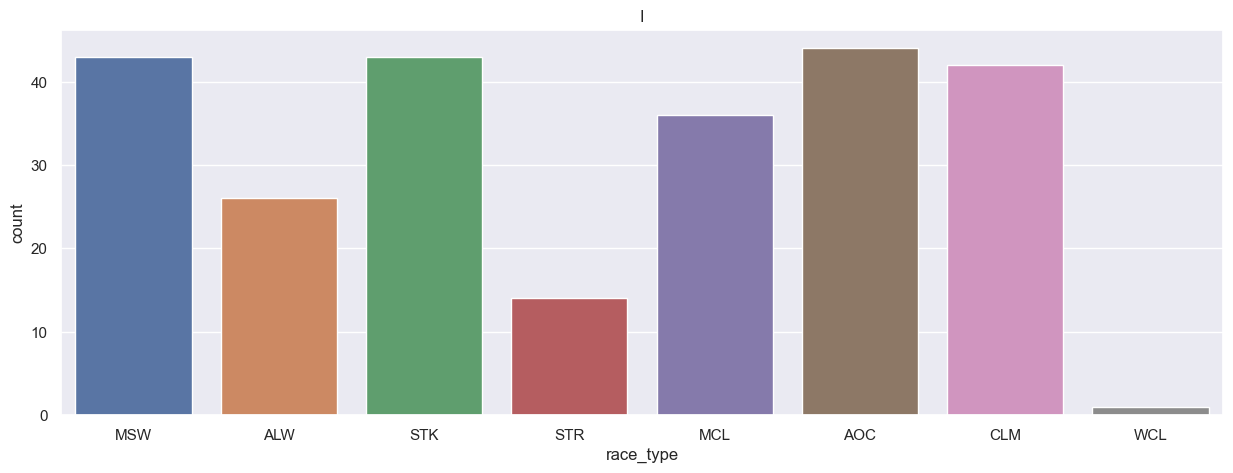

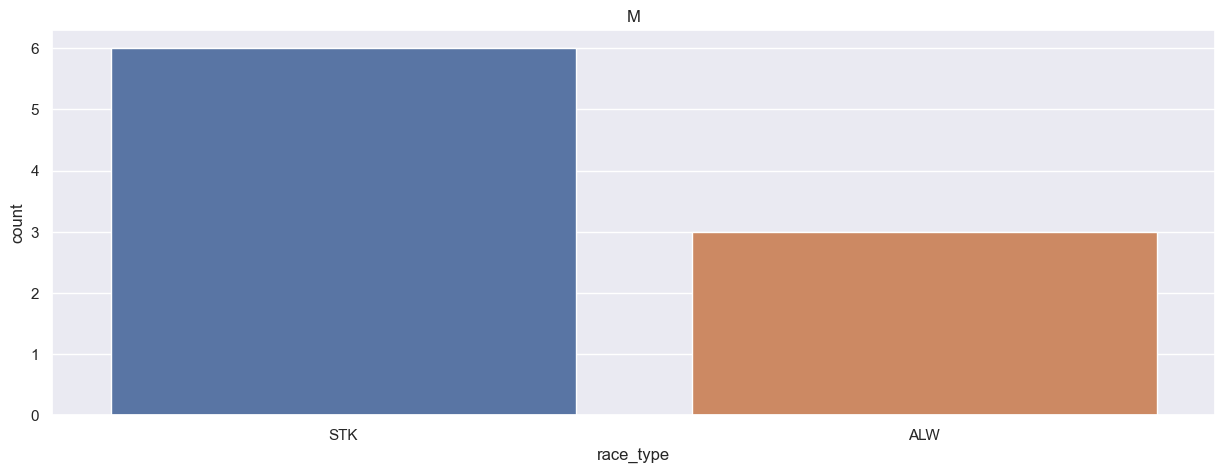

In [59]:
for c in df_race.course_type.unique():
    sns.countplot(data = df_race[df_race.course_type == c], x='race_type')
    plt.title(c)
    plt.show()

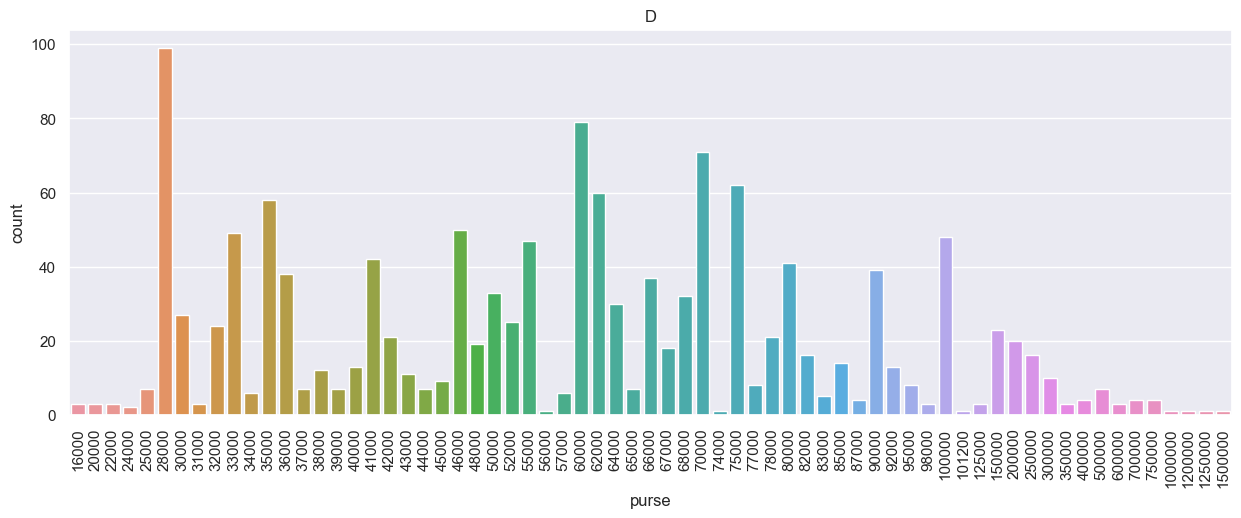

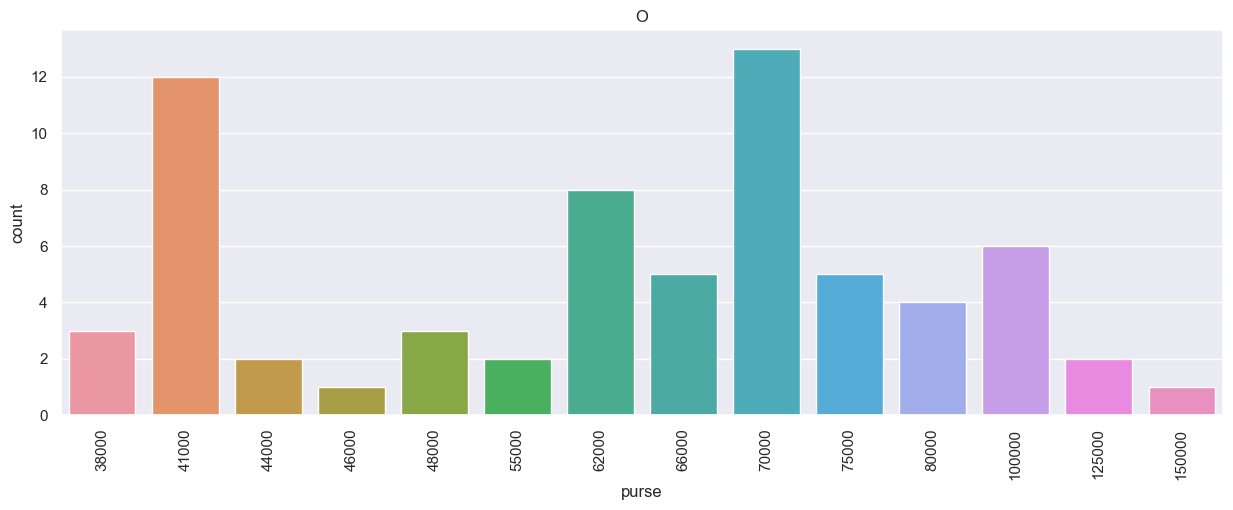

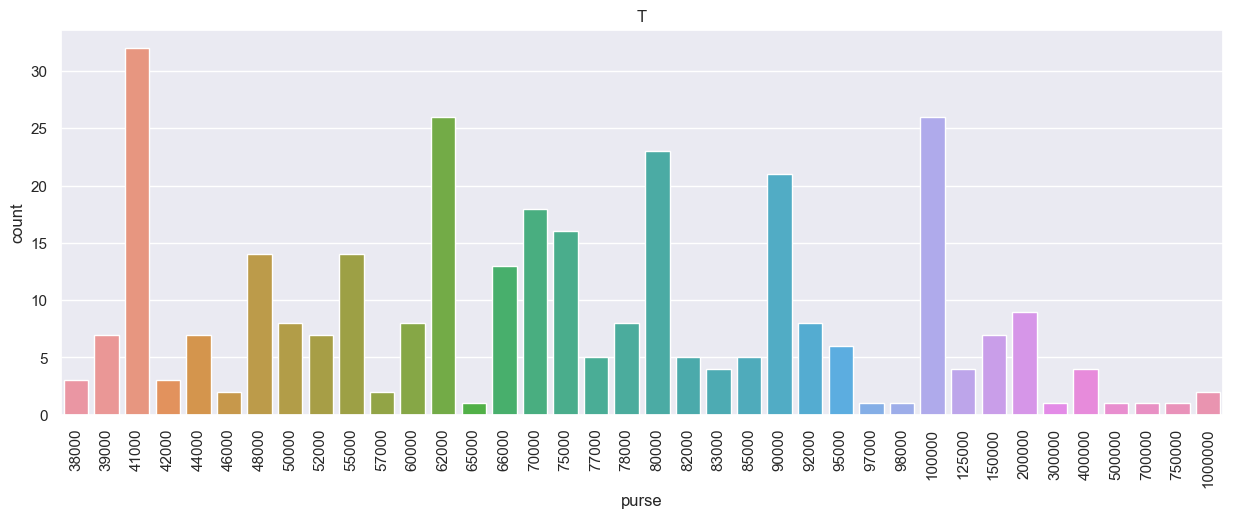

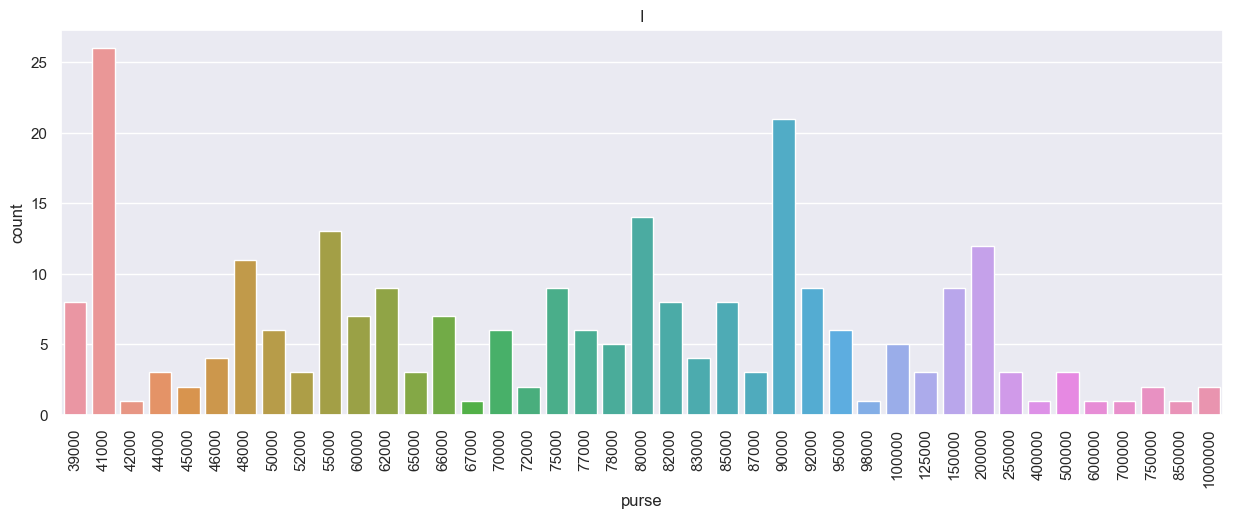

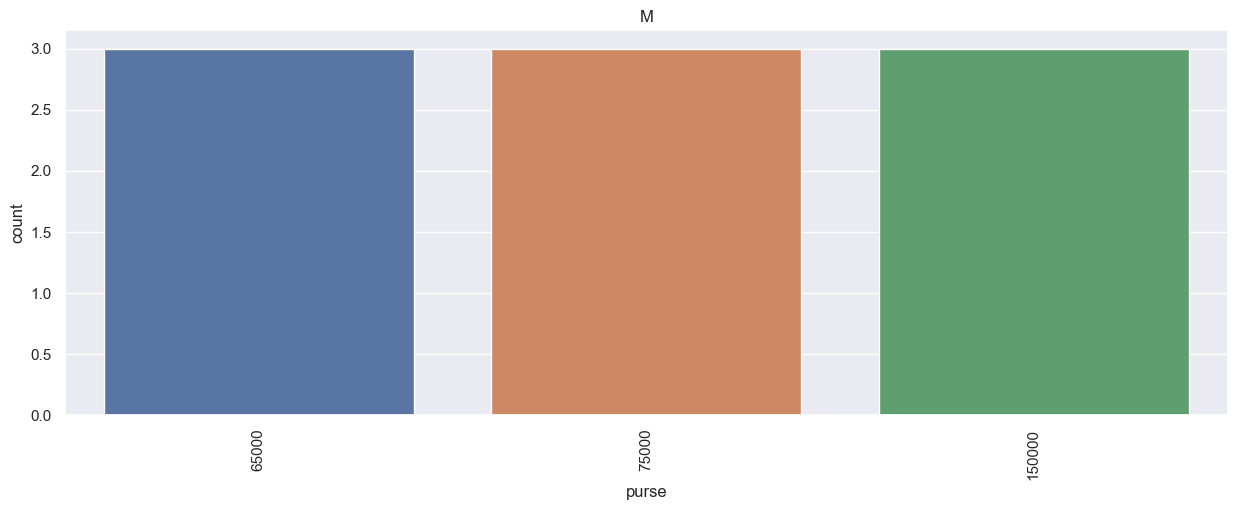

In [60]:
for c in df_race.course_type.unique():
    sns.countplot(data = df_race[df_race.course_type == c], x='purse')
    plt.title(c)
    plt.xticks(rotation=90)
    plt.show()

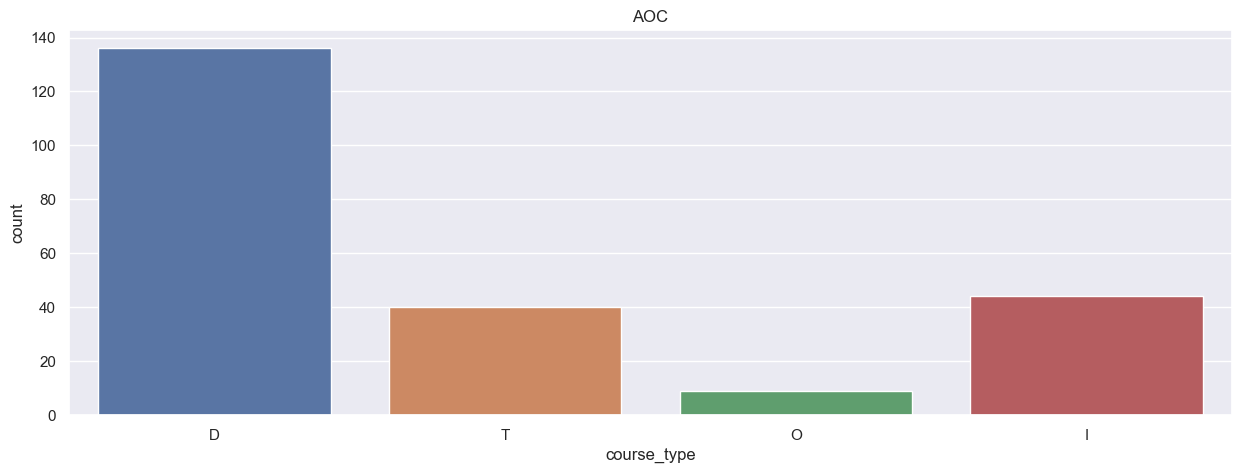

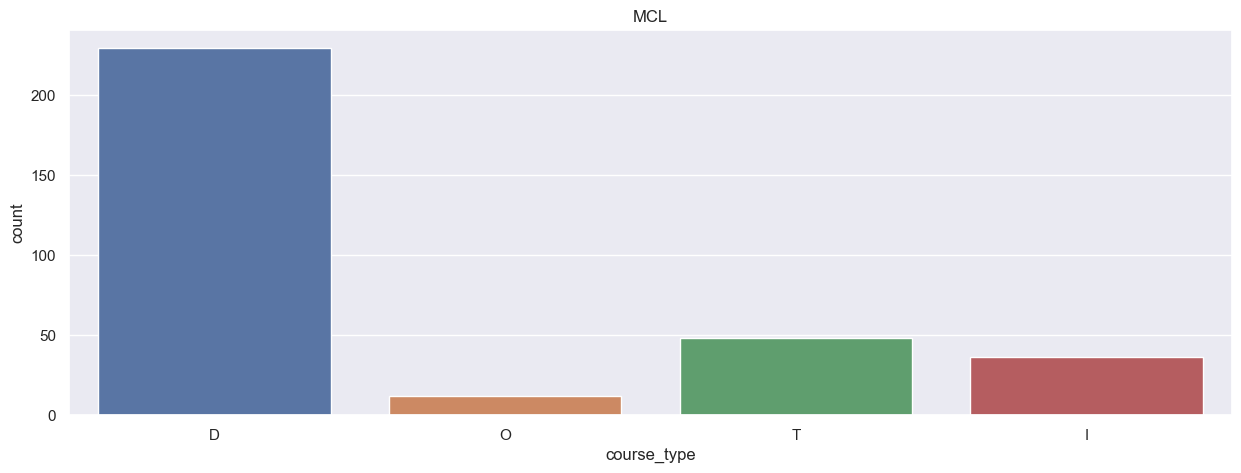

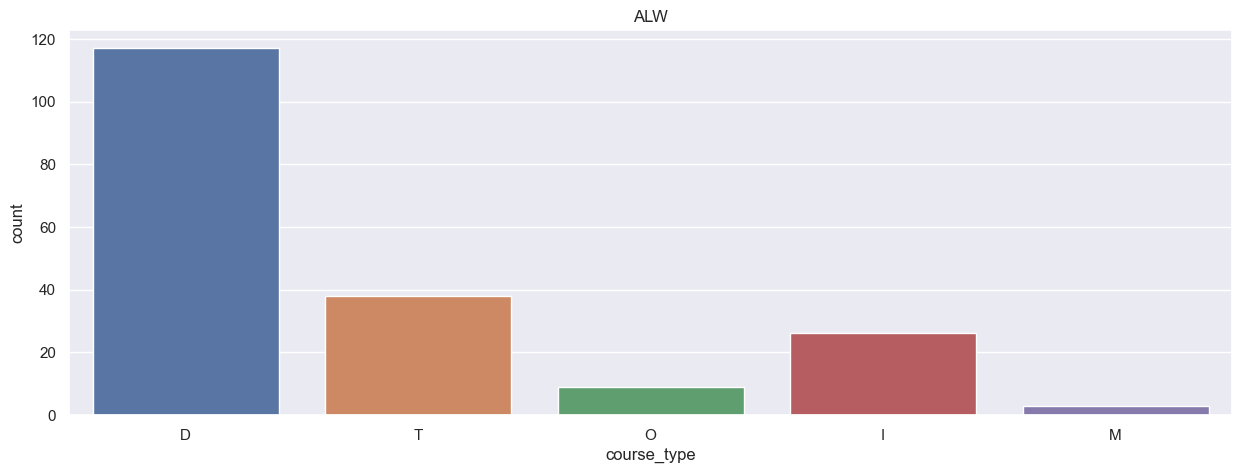

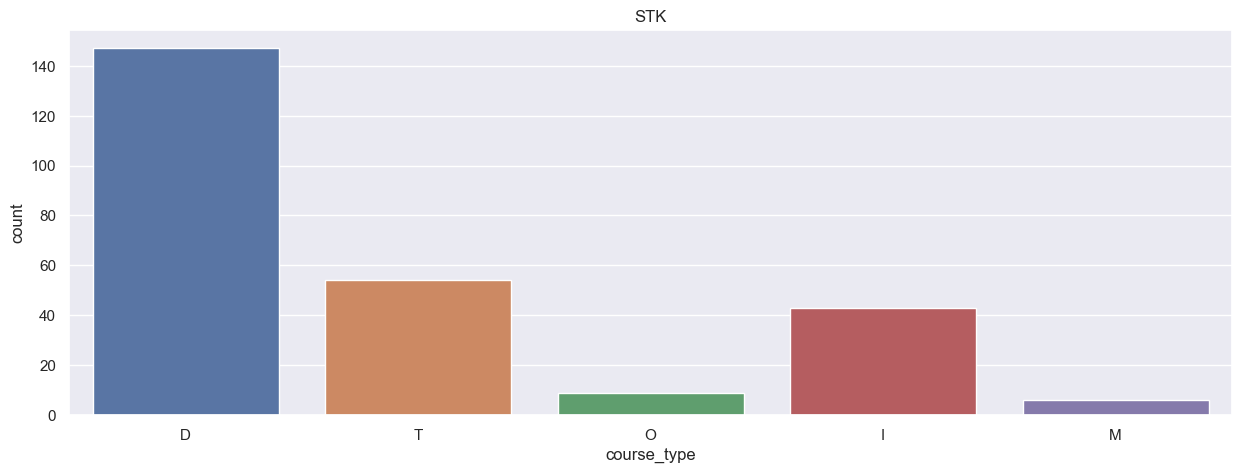

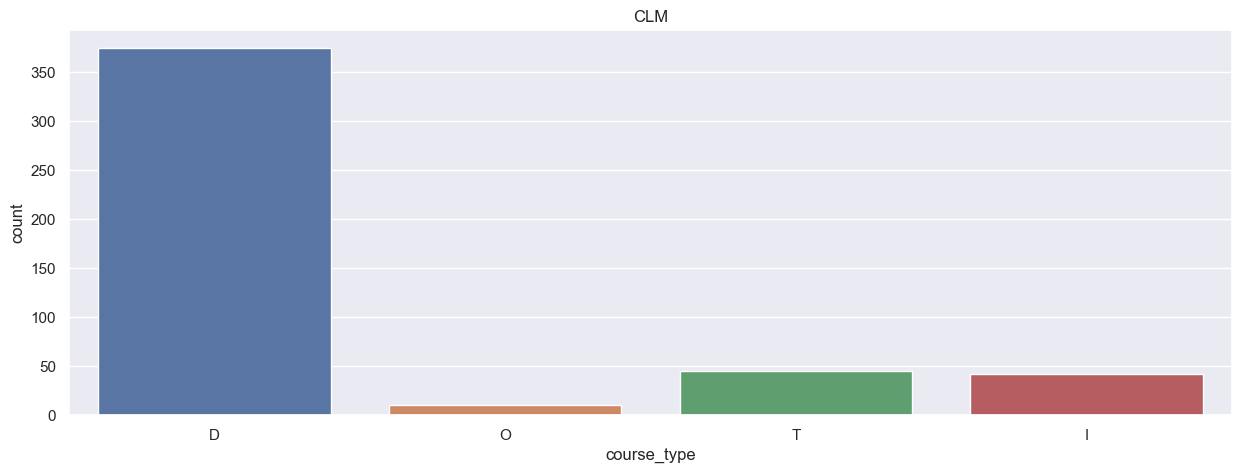

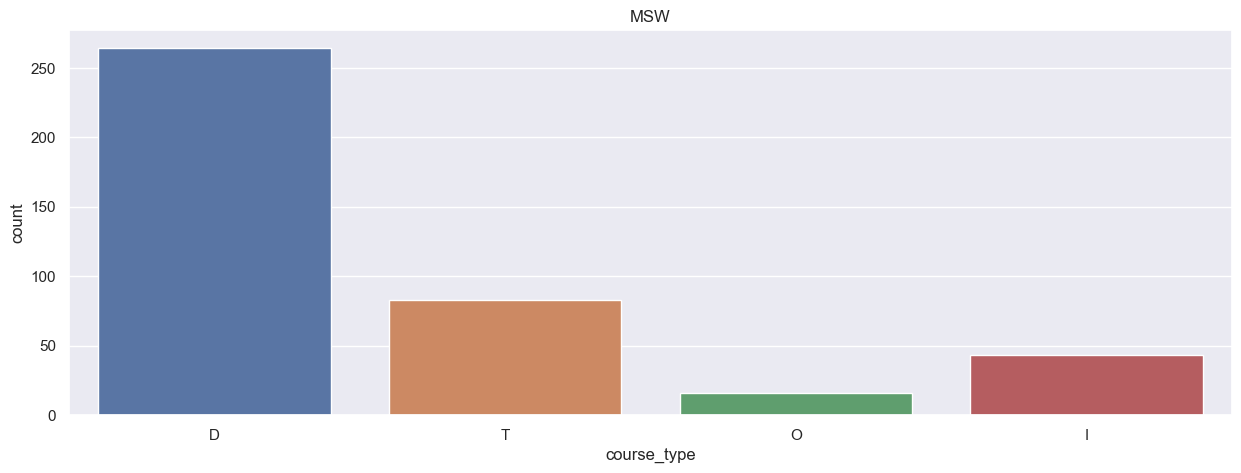

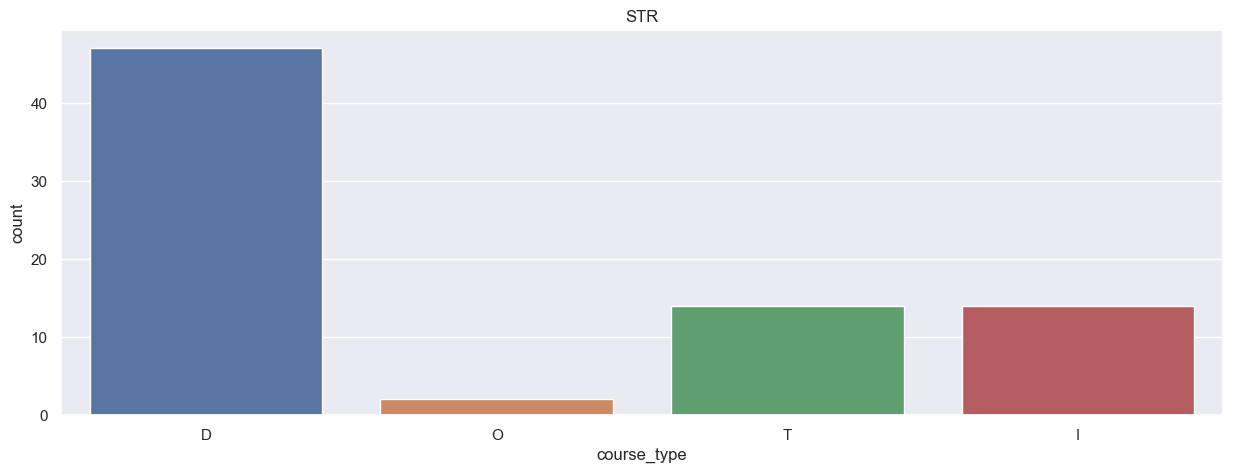

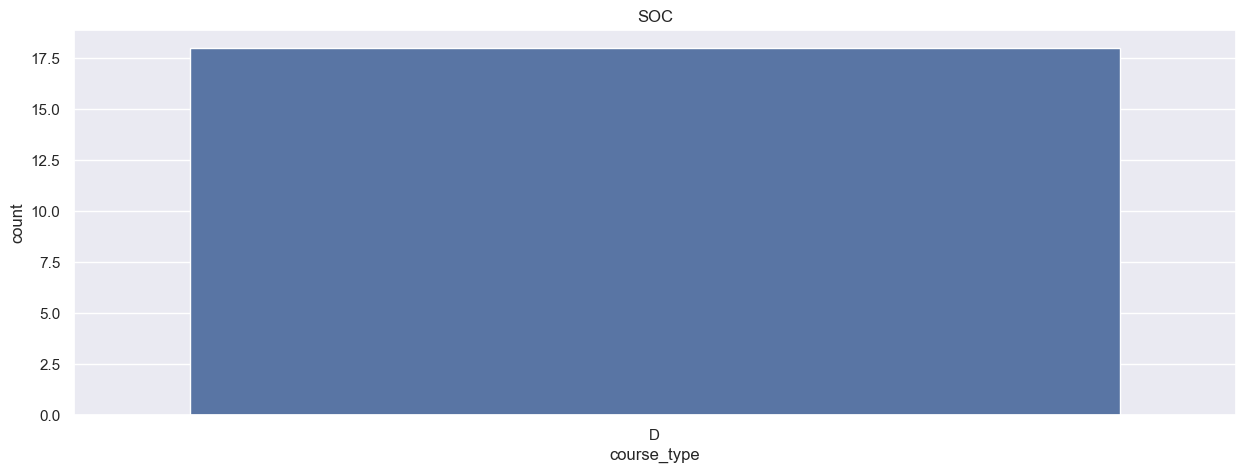

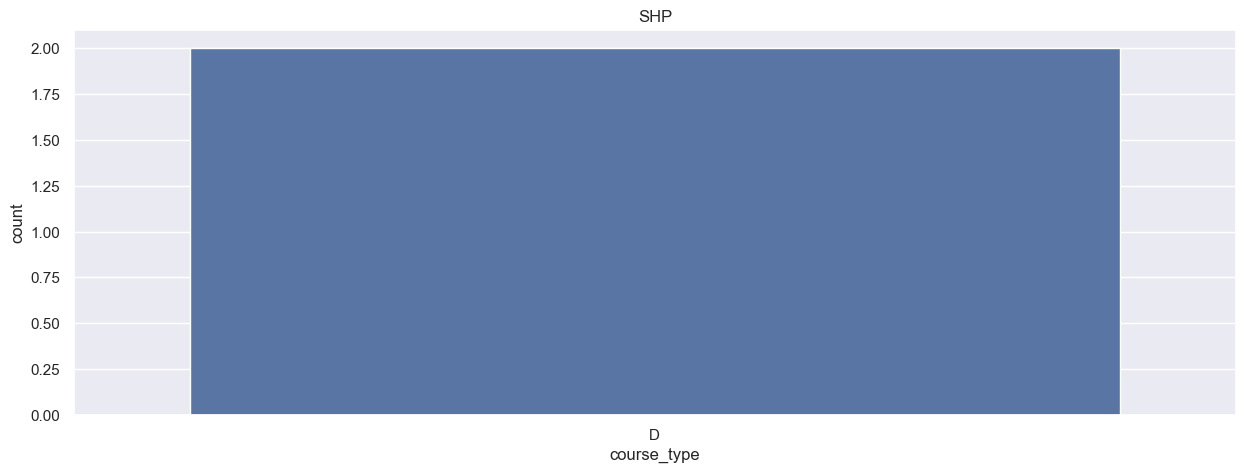

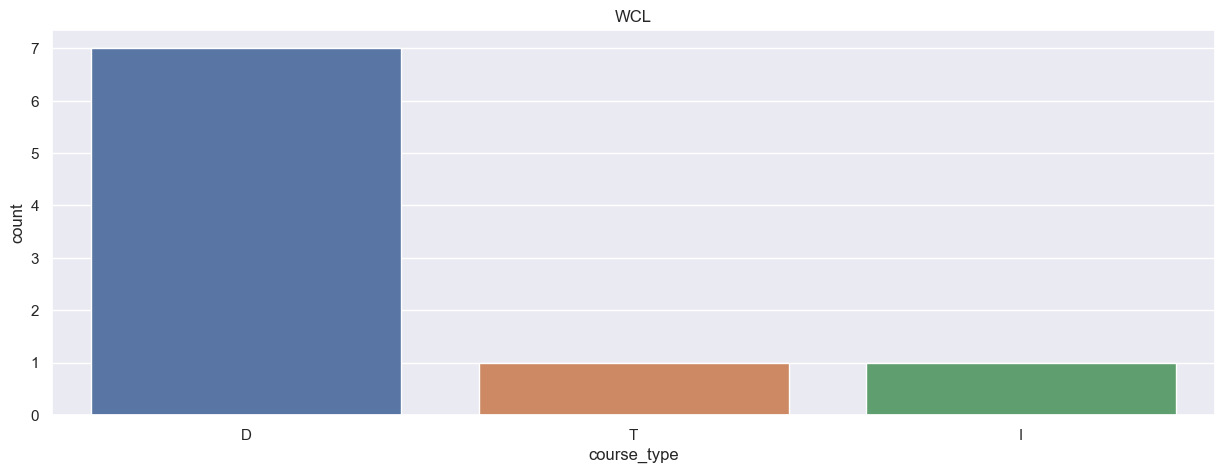

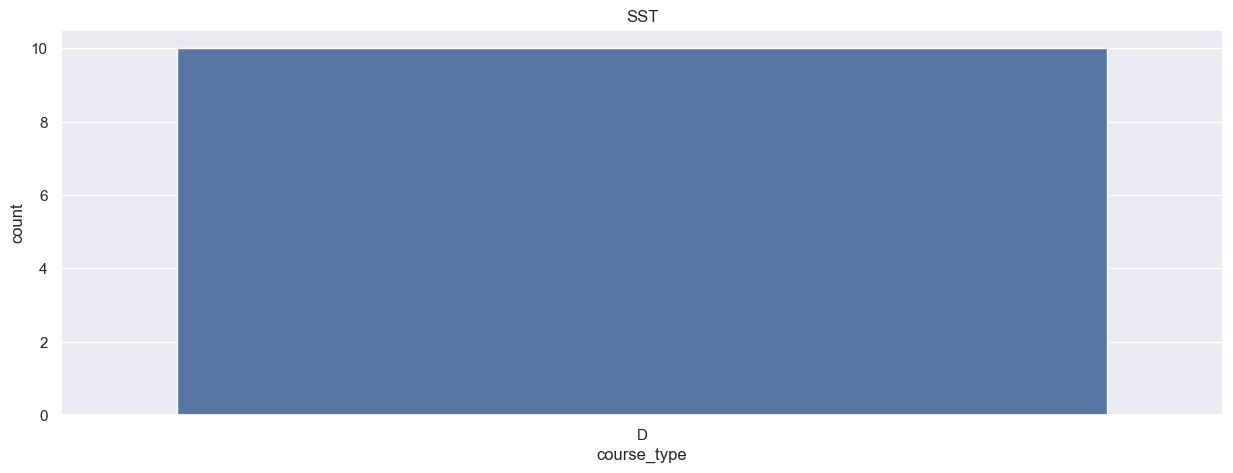

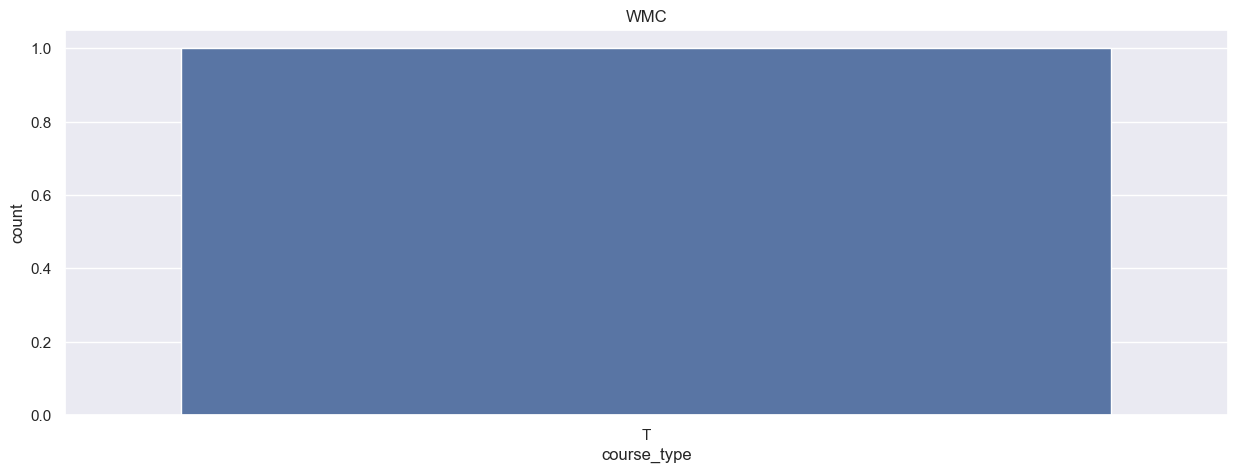

In [61]:
for c in df_race.race_type.unique():
    sns.countplot(data = df_race[df_race.race_type == c], x='course_type')
    plt.title(c)
    plt.show()

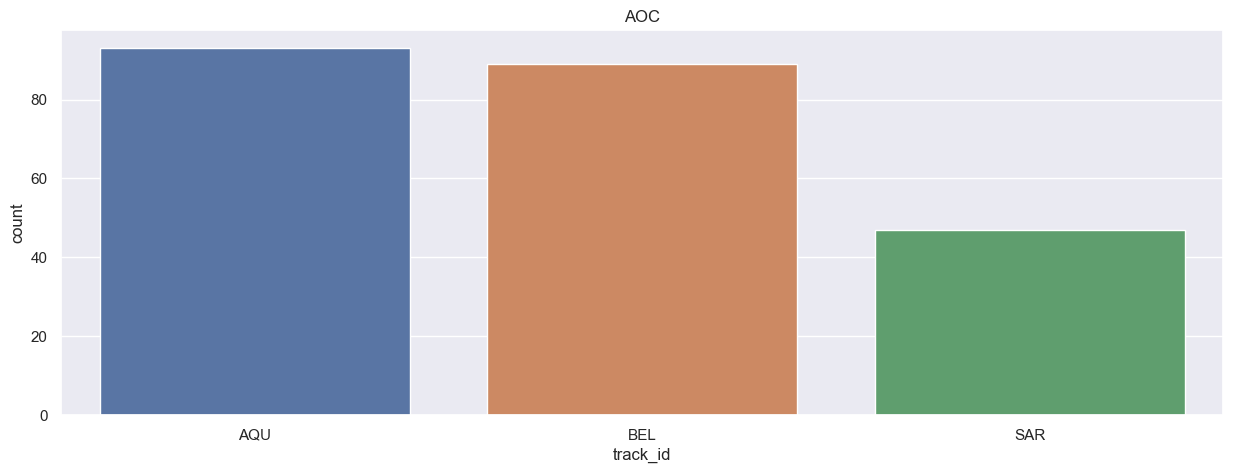

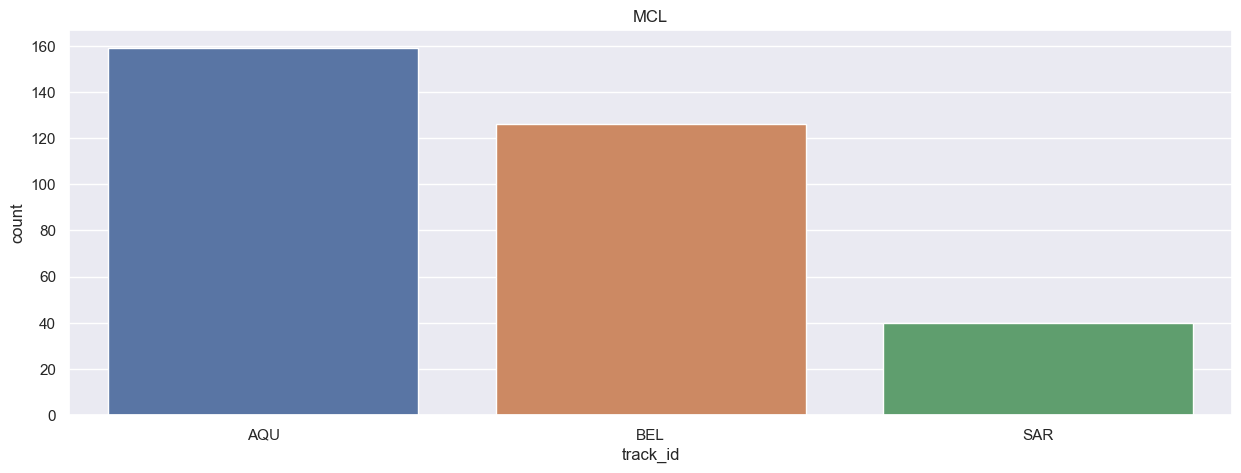

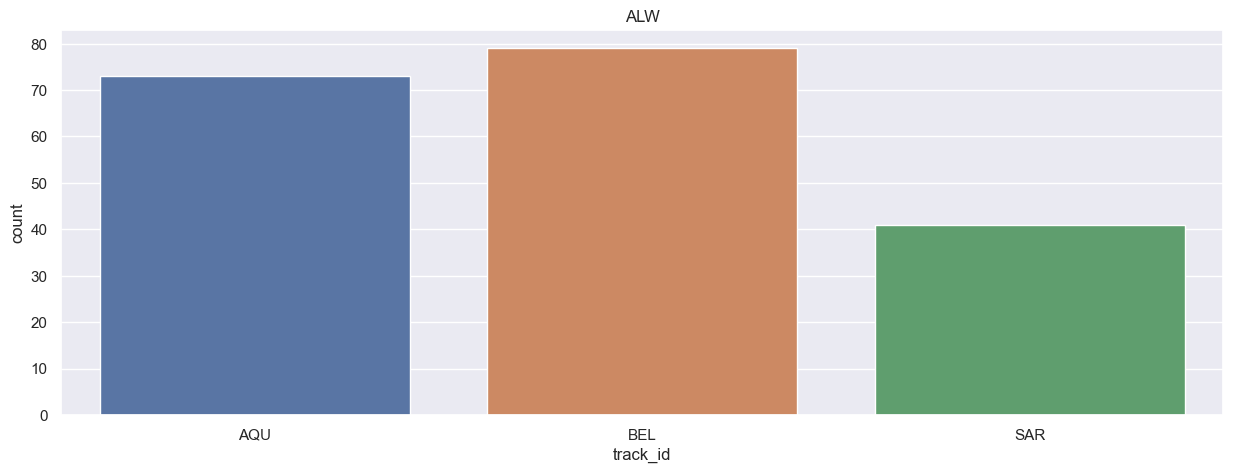

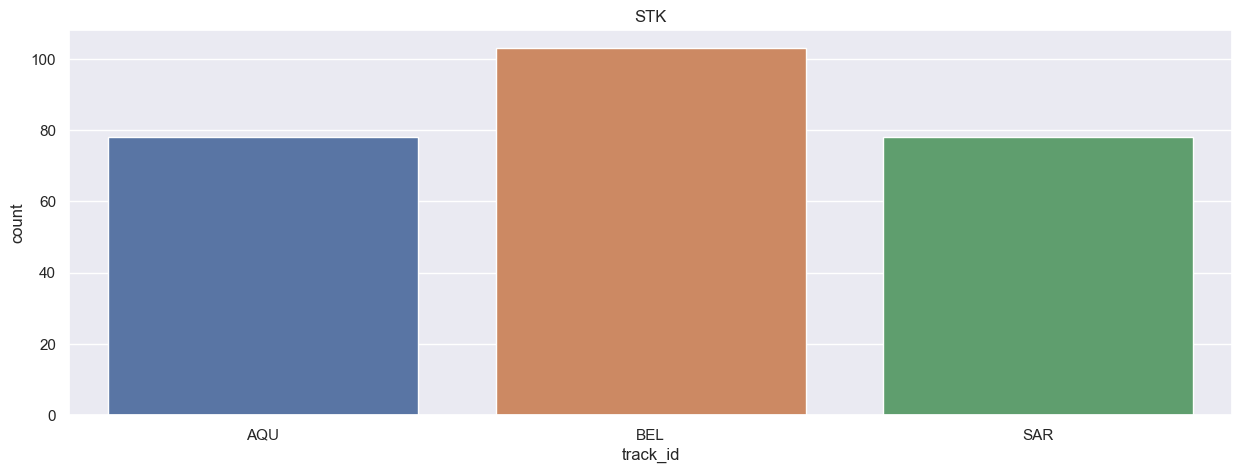

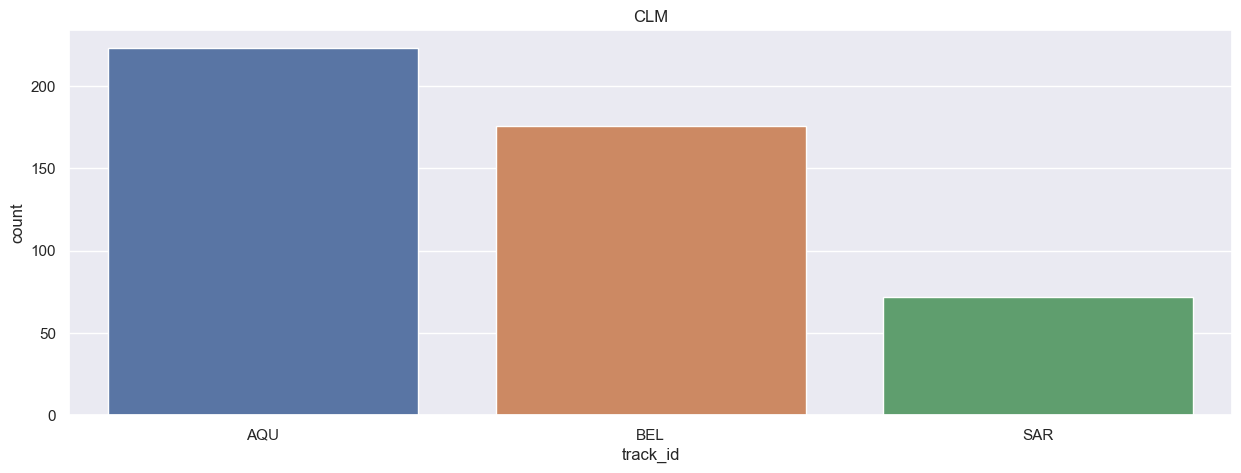

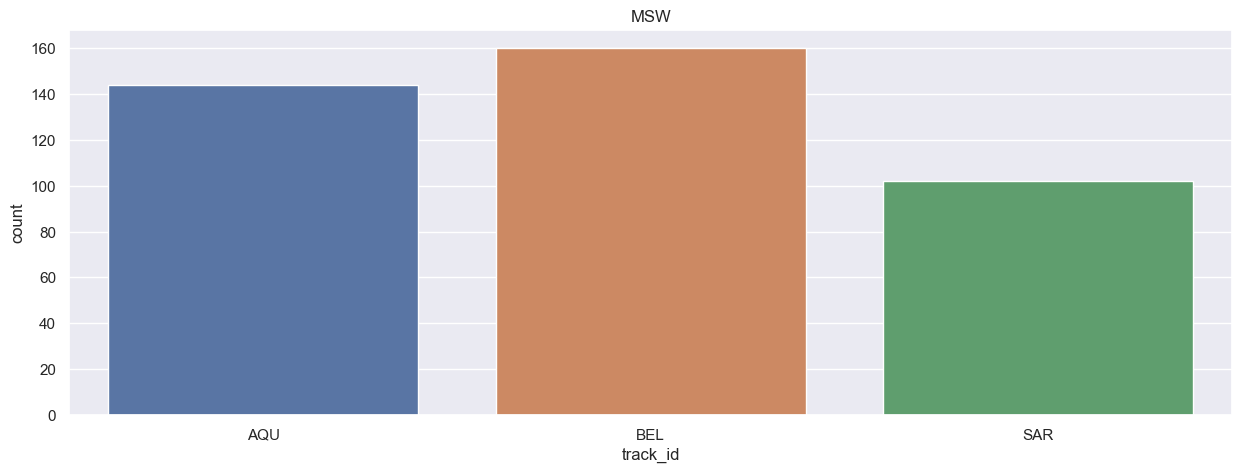

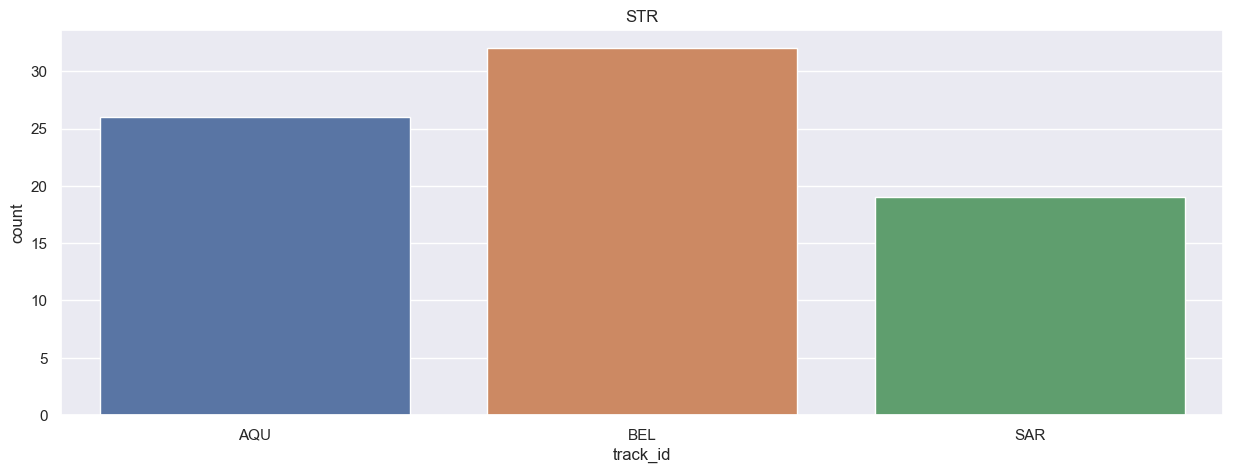

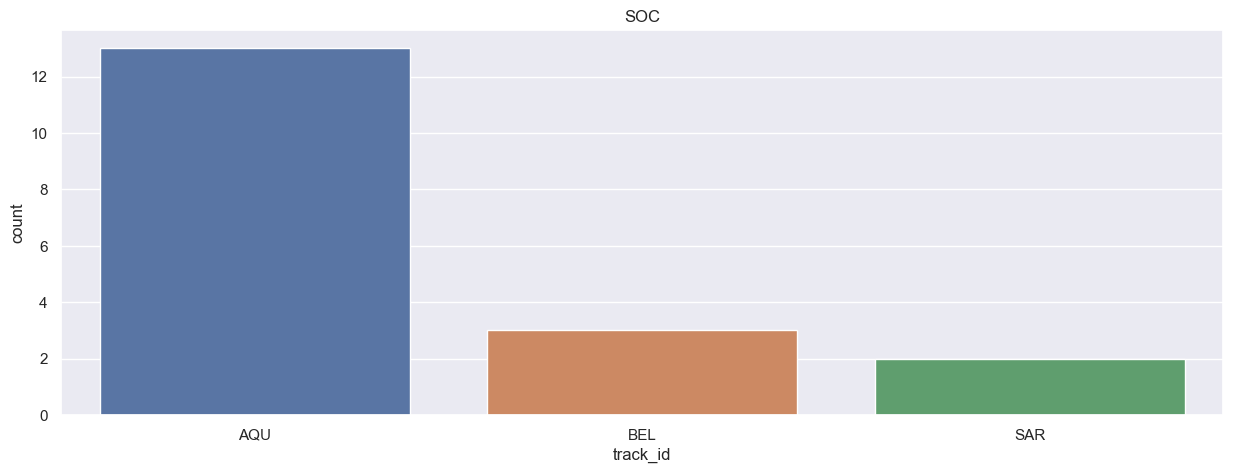

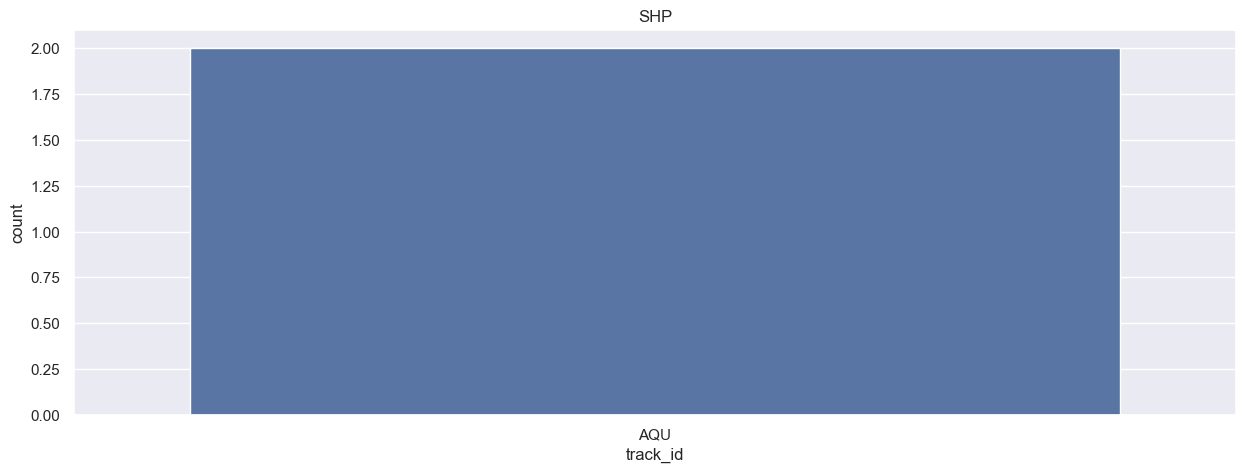

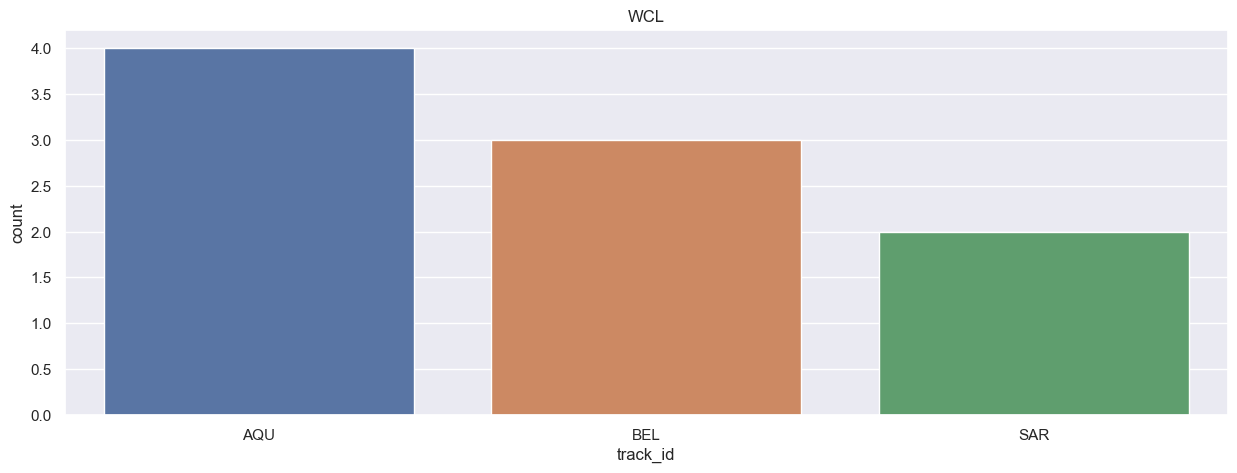

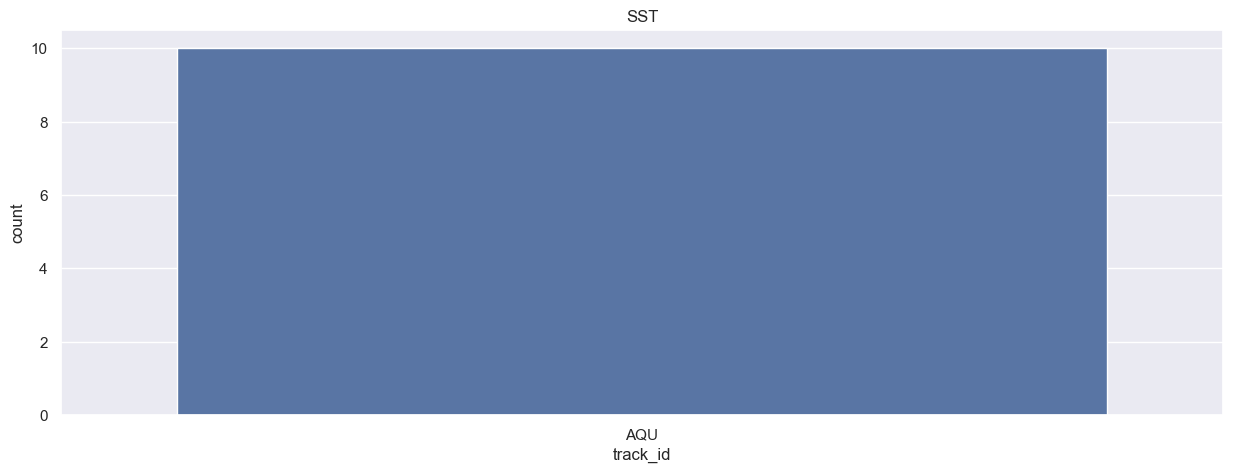

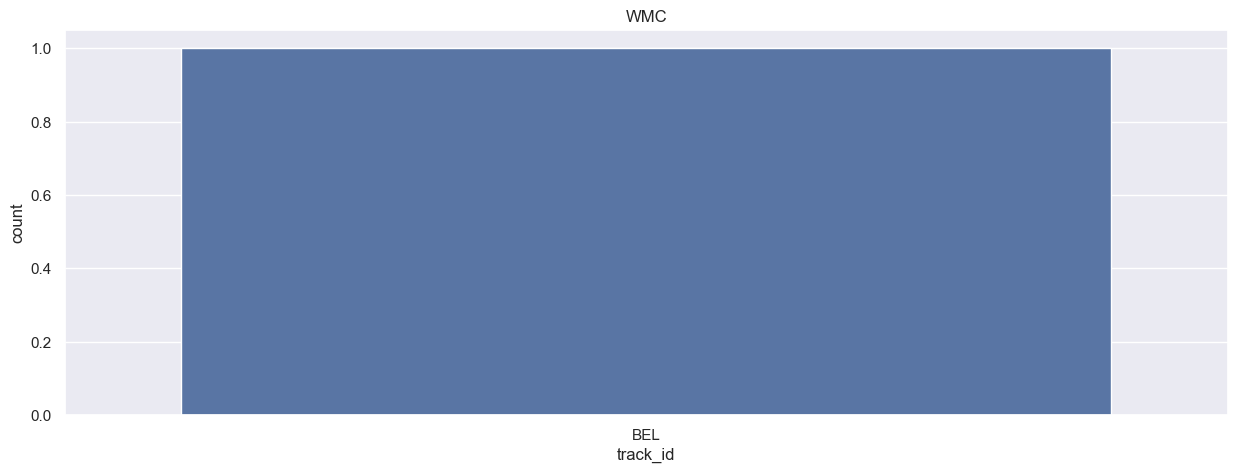

In [62]:
for c in df_race.race_type.unique():
    sns.countplot(data = df_race[df_race.race_type == c], x='track_id')
    plt.title(c)
    plt.show()

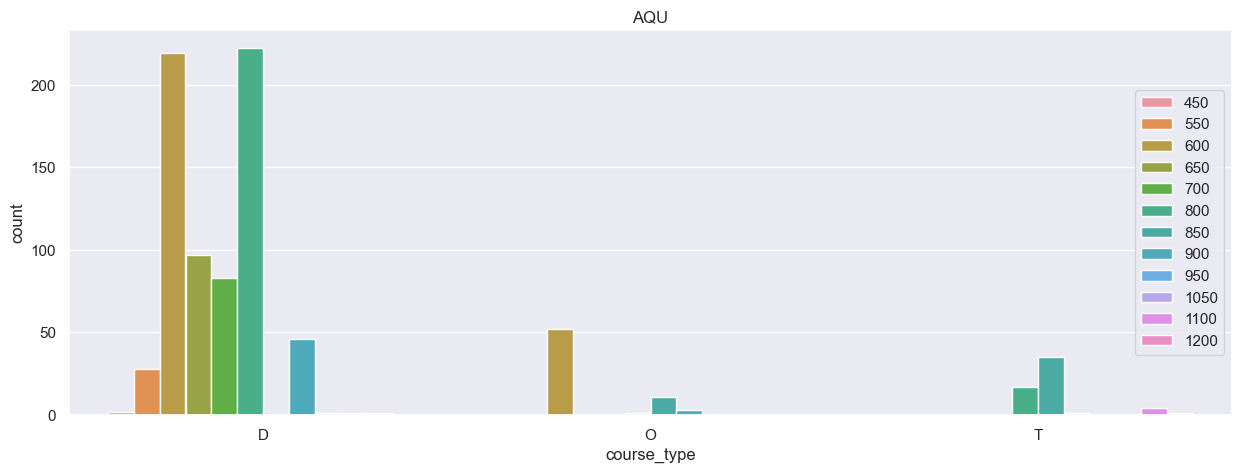

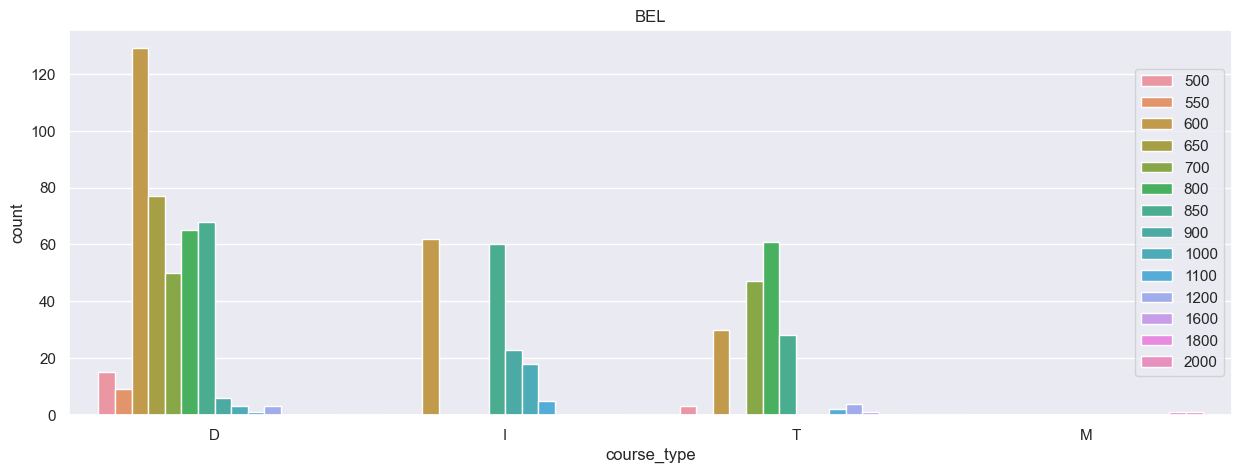

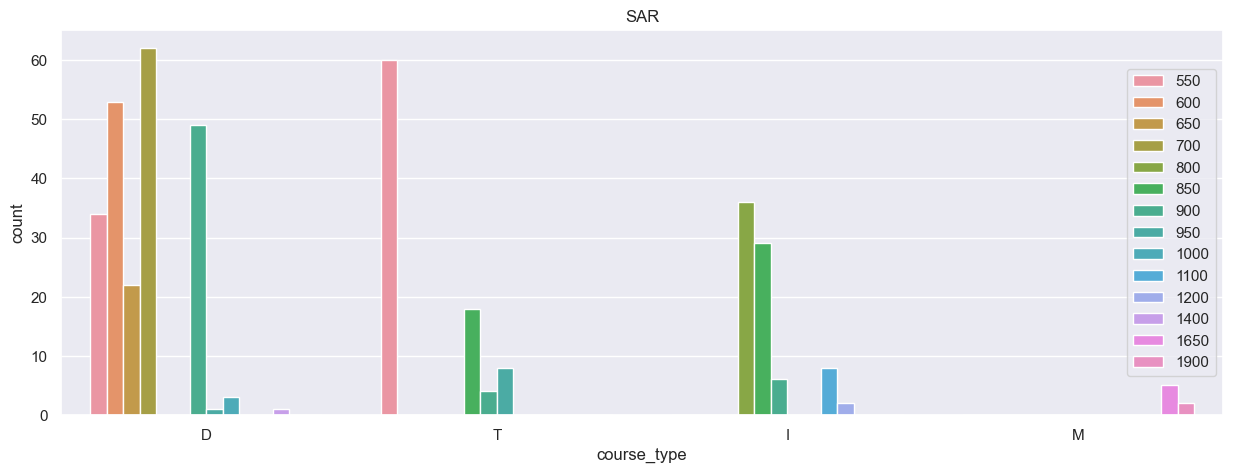

In [63]:
for t  in df_race.track_id.unique():
    sns.countplot(data = df_race[df_race.track_id == t], x='course_type', hue="distance_id")
    plt.title(t)
    plt.legend(loc='right')
    plt.show()

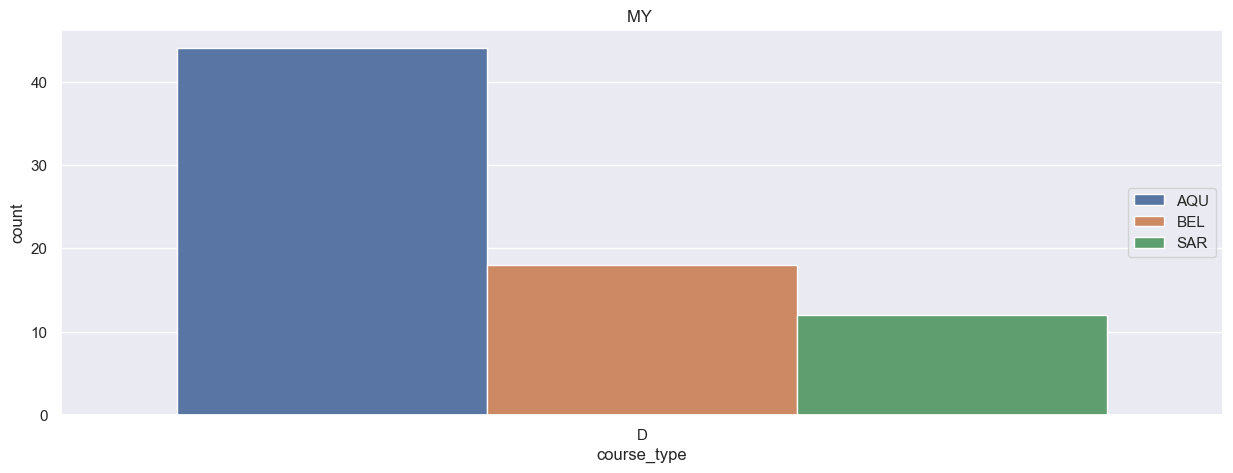

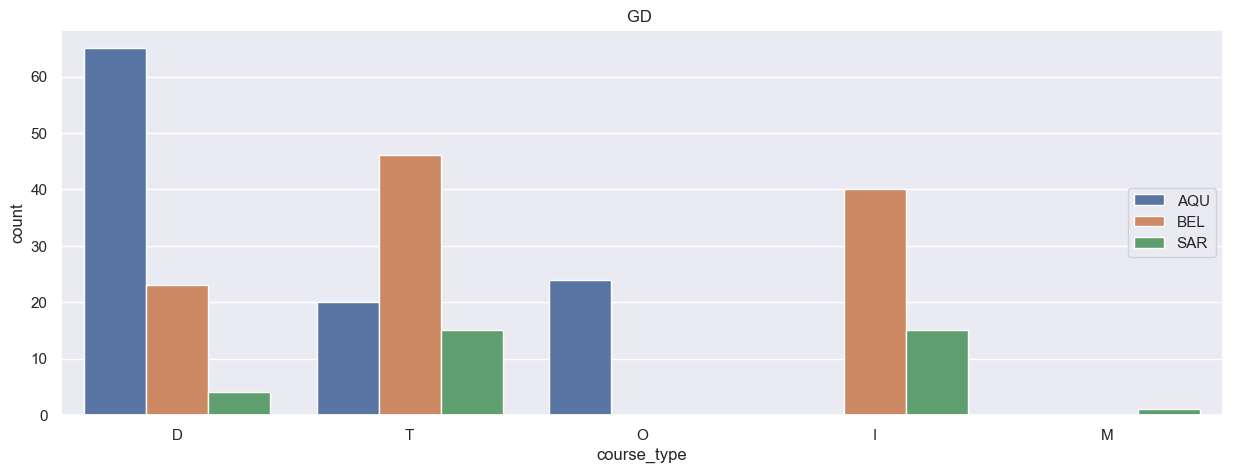

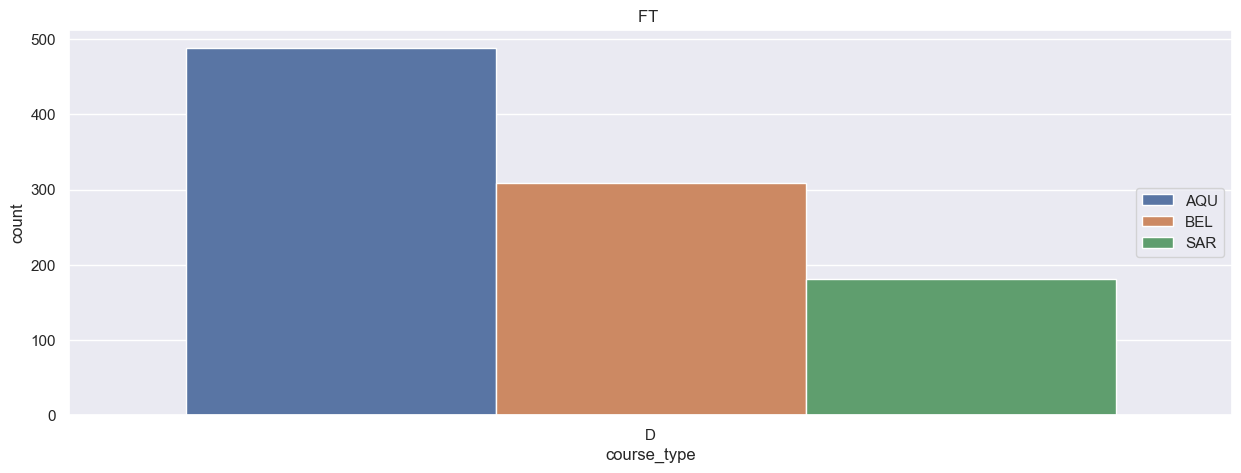

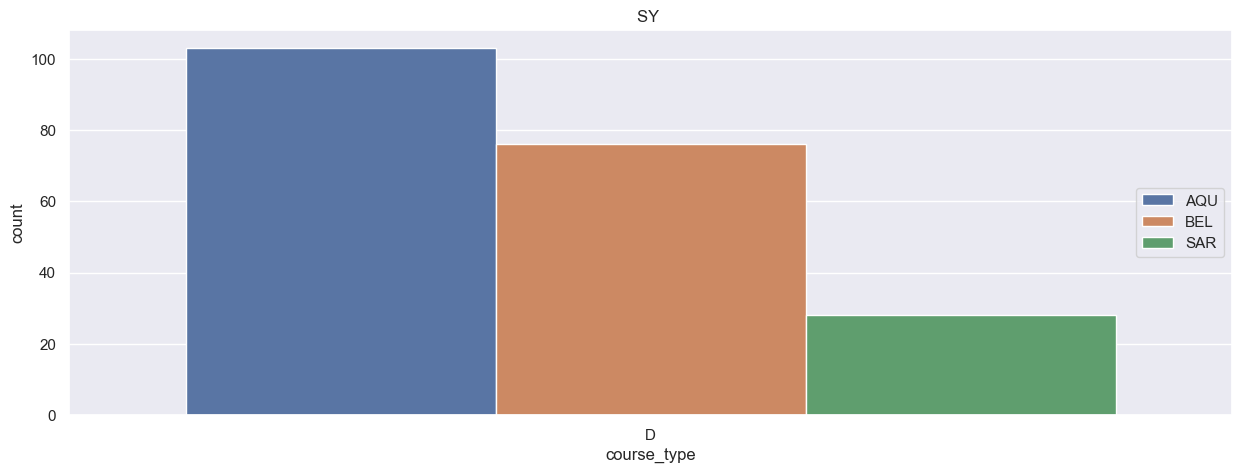

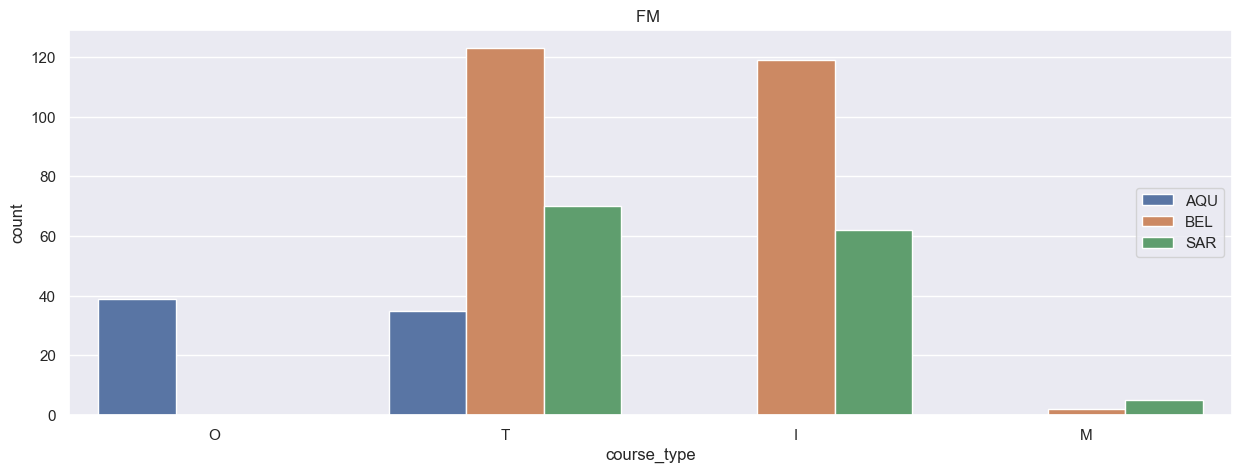

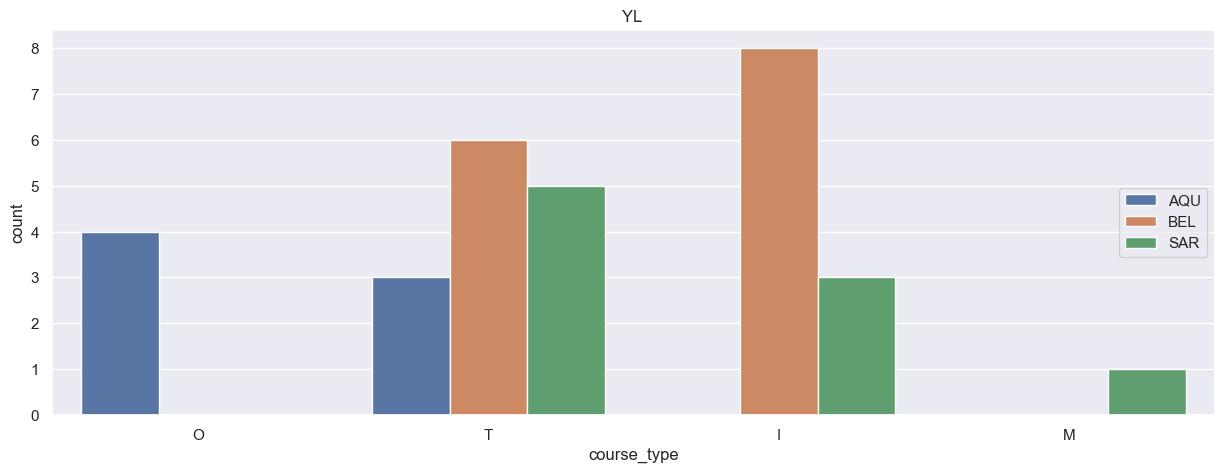

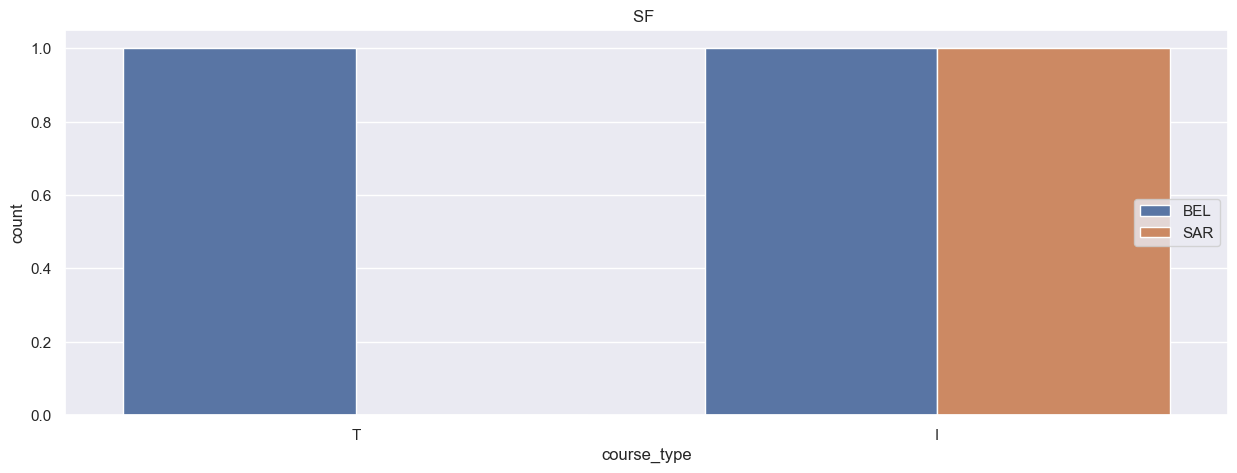

In [64]:
for t  in df_race.track_condition.unique():
    sns.countplot(data = df_race[df_race.track_condition == t], x='course_type', hue="track_id")
    plt.title(t)
    plt.legend(loc='right')
    plt.show()

### race_date

In [65]:
print('Race date period: ', df['race_date'].min(), '-', df_start['race_date'].max())

Race date period:  2019-01-01 00:00:00 - 2019-12-31 00:00:00


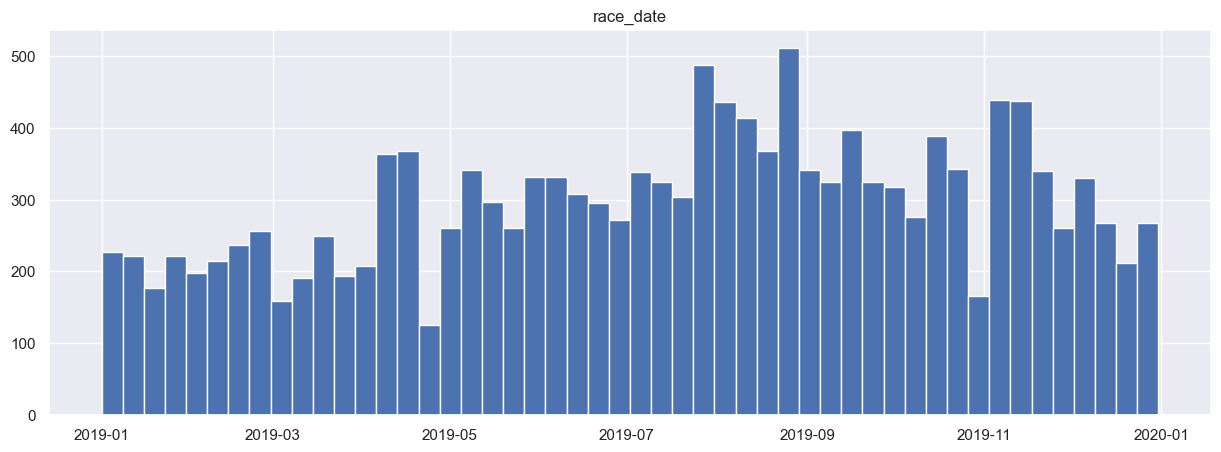

In [66]:
df_start.hist('race_date', bins = 50);

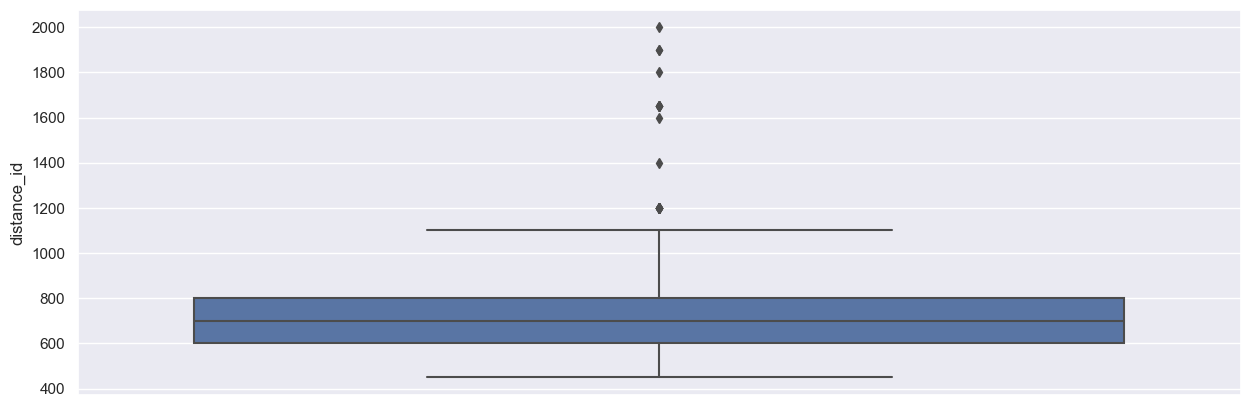

In [67]:
sns.boxplot(data = df_race, 
            y = df_race['distance_id']);

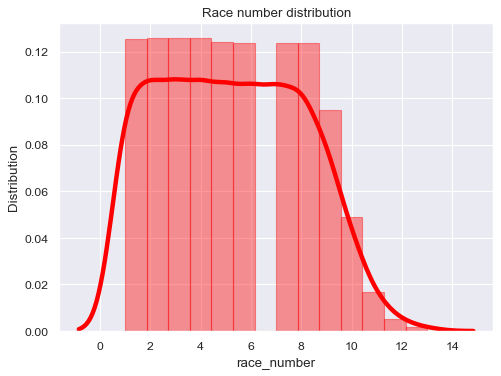

In [68]:
plt.figure(figsize=(7,5), dpi= 80)
sns.distplot(df_race['race_number'], hist=True, kde=True,
             bins=int(14), color = 'red', 
             hist_kws={'edgecolor':'red'},
             kde_kws={'linewidth': 4})
plt.title('Race number distribution')
plt.ylabel('Distribution');

## Weather data

Race results are closely linked to weather data. Let's add it to our dataset.

In [69]:
# Set time period
start = datetime(2019, 1, 1)
end_d = datetime(2019, 12, 31)
end = datetime(2019, 12, 31, 23, 59)

# Create Point
Saratoga = Point(43.071667, -73.768611)
Aqueduct = Point(40.672306, -73.830829)
Belmont = Point(40.715, -73.722778)

# Get horly data for 2019
Saratoga_h = Hourly(Saratoga, start, end)
Saratoga_h = Saratoga_h.fetch()

Aqueduct_h = Hourly(Aqueduct, start, end)
Aqueduct_h = Aqueduct_h.fetch()

Belmont_h = Hourly(Belmont, start, end)
Belmont_h = Belmont_h.fetch()

# Get daily data for 2019
Saratoga_d = Daily(Saratoga, start, end_d)
Saratoga_d = Saratoga_d.fetch()

Aqueduct_d = Daily(Aqueduct, start, end_d)
Aqueduct_d = Aqueduct_d.fetch()

Belmont_d = Daily(Belmont, start, end_d)
Belmont_d = Belmont_d.fetch()

In [70]:
Saratoga_h['track_id'] = 'SAR'
Aqueduct_h['track_id'] = 'AQU'
Belmont_h['track_id'] = 'BEL'
Saratoga_d['track_id'] = 'SAR'
Aqueduct_d['track_id'] = 'AQU'
Belmont_d['track_id'] = 'BEL'

In [71]:
weather_h = pd.concat([Saratoga_h, Aqueduct_h, Belmont_h], axis=0)
weather_d = pd.concat([Saratoga_d, Aqueduct_d, Belmont_d], axis=0)

In [72]:
display(weather_h.head())
weather_d.head()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,track_id
time,,,,,,,,,,,,
2019-01-01 00:00:00,1.0,0.0,93.0,NaN,NaN,129.0,11.1,NaN,1015.4,NaN,7.0,SAR
2019-01-01 01:00:00,6.2,6.2,100.0,NaN,NaN,143.0,11.1,NaN,1013.8,NaN,9.0,SAR
2019-01-01 02:00:00,1.0,0.0,93.0,NaN,NaN,160.0,11.1,NaN,1012.0,NaN,8.0,SAR
2019-01-01 03:00:00,2.0,1.0,93.0,NaN,NaN,177.0,11.1,NaN,1010.5,NaN,8.0,SAR
2019-01-01 04:00:00,7.8,7.8,100.0,NaN,NaN,183.0,11.1,NaN,1009.1,NaN,8.0,SAR


,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,track_id
time,,,,,,,,,,,
2019-01-01,3.9,-4.3,9.4,3.0,NaN,291.0,14.8,NaN,1013.8,NaN,SAR
2019-01-02,-4.5,-7.1,-2.1,0.0,NaN,142.0,5.0,NaN,1023.6,NaN,SAR
2019-01-03,-1.3,-4.3,4.4,2.3,NaN,282.0,6.1,NaN,1015.9,NaN,SAR
2019-01-04,1.7,-3.8,5.6,0.0,NaN,187.0,10.4,NaN,1013.7,NaN,SAR
2019-01-05,-0.7,-5.5,6.1,0.0,0.0,346.0,4.0,NaN,1002.5,NaN,SAR


In [73]:
df = df.merge(weather_h, how='left', left_on=['track_id', 'date_post_time'], right_on=['track_id', 'time'])

In [74]:
df[(df['race_date'] == '2019-07-12') & (df['race_number'] == 9)]

,track_id,race_date,race_number,program_number,trakus_index,latitude,longitude,distance_id,course_type,track_condition,...,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
188404,SAR,2019-07-12,9,4,1,43.072414,-73.769161,800,I,YL,...,16.0,51.0,NaN,NaN,301.0,22.2,NaN,1008.8,NaN,2.0
188405,SAR,2019-07-12,9,4,2,43.072412,-73.769167,800,I,YL,...,16.0,51.0,NaN,NaN,301.0,22.2,NaN,1008.8,NaN,2.0
188406,SAR,2019-07-12,9,4,3,43.072407,-73.769177,800,I,YL,...,16.0,51.0,NaN,NaN,301.0,22.2,NaN,1008.8,NaN,2.0
188407,SAR,2019-07-12,9,4,4,43.072401,-73.769195,800,I,YL,...,16.0,51.0,NaN,NaN,301.0,22.2,NaN,1008.8,NaN,2.0
188408,SAR,2019-07-12,9,4,5,43.072392,-73.769218,800,I,YL,...,16.0,51.0,NaN,NaN,301.0,22.2,NaN,1008.8,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5030914,SAR,2019-07-12,9,1,8,43.072337,-73.769273,800,I,YL,...,16.0,51.0,NaN,NaN,301.0,22.2,NaN,1008.8,NaN,2.0
5030915,SAR,2019-07-12,9,1,9,43.072321,-73.769307,800,I,YL,...,16.0,51.0,NaN,NaN,301.0,22.2,NaN,1008.8,NaN,2.0
5030916,SAR,2019-07-12,9,1,10,43.072304,-73.769344,800,I,YL,...,16.0,51.0,NaN,NaN,301.0,22.2,NaN,1008.8,NaN,2.0
5030917,SAR,2019-07-12,9,1,11,43.072288,-73.769381,800,I,YL,...,16.0,51.0,NaN,NaN,301.0,22.2,NaN,1008.8,NaN,2.0


Thank you